# AI in Industry Project - Fairness in Hiring Process (Adecco)
### The aim of this project is to study the fairness of the HR Process employed by Adecco
### The dataset used in this notebook is the reverse one
### The steps employed in this project are:
#### 1. Data Exploration
#### 2. Bias Detection (AI Fairness 360 toolkit); sensitive attributes such as gender, age, domicile region have been considered wrt. the match score the candidates have been given
#### 3. Bias Mitigation (Reweight and Disparate Impact Remover)
#### 4. Appendix: Here, additional tests for detecting bias have been employed to double-check the previously obtained results such as FairLearn, KL Divergence, Chi-square, Cramer's V, Wasserstein Distance



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder

In [ ]:
rm_df = pd.read_csv("reverse_matching_20240213_eng.csv", encoding = "Windows-1252", sep=";")

In [ ]:
rm_df.head()

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province
0,"11,208",OFF_3435_4864,30.609745,99.309860,1,Female,25-34,VE,VENETO,"Master's Degree: Economics for arts, culture a...",Search and selection,secretary/secretary,Secretariat / General Services,TV
1,"11,208",ORD_13361_0218,42.466312,96.529259,1,Female,25-34,VE,VENETO,"Master's Degree: Economics for arts, culture a...",Subordinate employment,Employee (m/f),Secretariat / General Services,PN
2,"11,208",ORD_14183_0606,33.240650,95.374954,2,Female,25-34,VE,VENETO,"Master's Degree: Economics for arts, culture a...",Subordinate employment,Human Resources Officer (m/f),Human Resources / Recruitment,TV
3,"11,208",OFF_635_0402,58.744339,94.199844,2,Female,25-34,VE,VENETO,"Master's Degree: Economics for arts, culture a...",Search and selection,Telemarketing operator,Call Center / Customer Care,PD
4,"11,208",OFF_5814_0606,27.851854,93.688522,3,Female,25-34,VE,VENETO,"Master's Degree: Economics for arts, culture a...",Subordinate employment,Administrative Assistant,Finance / Accounting,TV


In [ ]:
rm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193474 entries, 0 to 193473
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   cand_id                    193474 non-null  object 
 1   job_id                     193474 non-null  object 
 2   distance_km                193474 non-null  float64
 3   match_score                193474 non-null  float64
 4   match_rank                 193474 non-null  int64  
 5   cand_gender                193474 non-null  object 
 6   cand_age_bucket            193474 non-null  object 
 7   cand_domicile_province     190635 non-null  object 
 8   cand_domicile_region       193454 non-null  object 
 9   cand_education             70645 non-null   object 
 10  job_contract_type          193474 non-null  object 
 11  job_professional_category  192884 non-null  object 
 12  job_sector                 192876 non-null  object 
 13  job_work_province          16

cand_domicile_province has 190635 entries out of 193474 which means that there are missing ones. Same goes for cand_domicile_region, cand_education, job_professional_category, job_sector, job_work_province

In [ ]:
print(rm_df.duplicated(subset=['cand_id', 'job_id']).sum())

0


In [ ]:
#the null values are substituted with default values
rm_df['cand_education'] = rm_df['cand_education'].fillna('Not disclosed')
rm_df['job_professional_category'] = rm_df['job_professional_category'].fillna('Not disclosed')
rm_df['cand_domicile_province'] = rm_df['cand_domicile_province'].fillna('Not disclosed')
rm_df['cand_domicile_region'] = rm_df['cand_domicile_region'].fillna('Not disclosed')
rm_df['job_sector'] = rm_df['job_sector'].fillna('Not disclosed')
rm_df['job_work_province'] = rm_df['job_work_province'].fillna('Not disclosed')

In [ ]:
rm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193474 entries, 0 to 193473
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   cand_id                    193474 non-null  object 
 1   job_id                     193474 non-null  object 
 2   distance_km                193474 non-null  float64
 3   match_score                193474 non-null  float64
 4   match_rank                 193474 non-null  int64  
 5   cand_gender                193474 non-null  object 
 6   cand_age_bucket            193474 non-null  object 
 7   cand_domicile_province     193474 non-null  object 
 8   cand_domicile_region       193474 non-null  object 
 9   cand_education             193474 non-null  object 
 10  job_contract_type          193474 non-null  object 
 11  job_professional_category  193474 non-null  object 
 12  job_sector                 193474 non-null  object 
 13  job_work_province          19

### Top Applicants

In [ ]:
rm_top_applicants = rm_df[rm_df['match_rank'] == 1]
rm_top_applicants.head()

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province
0,"11,208",OFF_3435_4864,30.609745,99.309860,1,Female,25-34,VE,VENETO,"Master's Degree: Economics for arts, culture a...",Search and selection,secretary/secretary,Secretariat / General Services,TV
1,"11,208",ORD_13361_0218,42.466312,96.529259,1,Female,25-34,VE,VENETO,"Master's Degree: Economics for arts, culture a...",Subordinate employment,Employee (m/f),Secretariat / General Services,PN
10,"14,714",OFF_1152_0073,12.972174,99.949570,1,Male,55-74,BS,LOMBARDIA,Not disclosed,Search and selection,Molding machine toolmaker (m/f),Specialized workers,BS
11,"14,714",ORD_16202_0319,30.324381,99.900505,1,Male,55-74,BS,LOMBARDIA,Not disclosed,Subordinate employment,General Textile Worker,General Workers,BS
21,"18,979",OFF_1464_1800,17.182215,99.951118,1,Female,55-74,PR,EMILIA ROMAGNA,Not disclosed,Search and selection,General Chemical/Pharmaceutical Worker,General Workers,PR


In [ ]:
rm_top_applicants.shape

(41985, 14)

# Data Exploration

### 1. Age

In [ ]:
custom_order = ['15-24', '25-34', '35-44',
                '45-54', '55-74', 'blank']
rm_df['cand_age_bucket'] = pd.Categorical(rm_df['cand_age_bucket'], categories=custom_order, ordered=True)
     


Text(0, 0.5, 'Frequency')

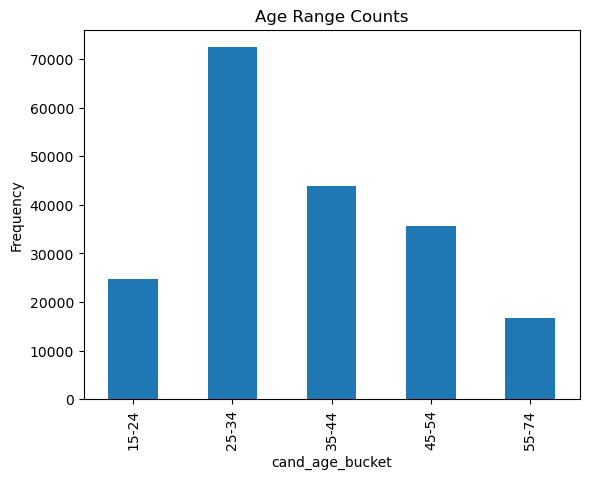

In [ ]:

age_range_counts = Counter(rm_df['cand_age_bucket'].sort_values())
age_range_df = pd.DataFrame(age_range_counts.items(), columns=['cand_age_bucket', 'Count'])
age_range_df.plot(x='cand_age_bucket', y='Count', kind='bar', legend=False)
plt.title('Age Range Counts')
plt.ylabel('Frequency')
     

### 1.1 Age of the Top Applicants

Text(0, 0.5, 'Frequency')

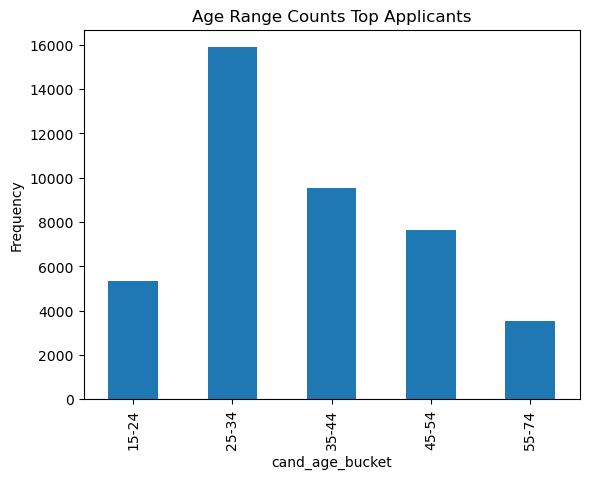

In [ ]:
age_range_counts = Counter(rm_top_applicants['cand_age_bucket'].sort_values())
age_range_df = pd.DataFrame(age_range_counts.items(), columns=['cand_age_bucket', 'Count'])
age_range_df.plot(x='cand_age_bucket', y='Count', kind='bar', legend=False)
plt.title('Age Range Counts Top Applicants')
plt.ylabel('Frequency')

We can see that the preferred age group considering the whole dataset as well as checking it up just for the top applicants is 25-34 years old.

### 2. Gender

([<matplotlib.patches.Wedge at 0x130696210>,
 [Text(-0.7201019230076691, -0.831536662138632, 'Female'),
  Text(0.7201020008617474, 0.8315365947178202, 'Male')],
 [Text(-0.3927828670950922, -0.4535654520756174, '49.5%'),
  Text(0.3927829095609531, 0.4535654153006291, '50.5%')])

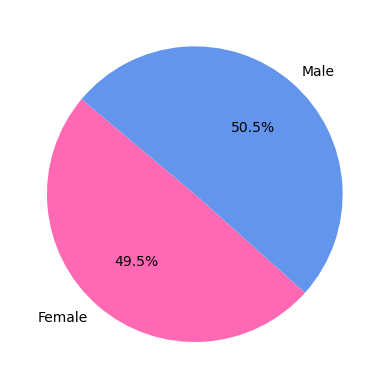

In [ ]:
sex_distrib = Counter(rm_df['cand_gender'])
sex_distrib_df = pd.DataFrame(sex_distrib.items(), columns=['cand_gender', 'Count'])

labels = sex_distrib_df['cand_gender']
sizes = sex_distrib_df['Count']

custom_palette = ["#FF69B4", "#6495ED"]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=custom_palette)

From the pie chart we can see that the distribution between male and female is almost equal, which means that there is close to zero bias regarding the gender

### 2.1 Gender of the Top Applicants

([<matplotlib.patches.Wedge at 0x130780d90>,
 [Text(-0.7298447900058096, -0.8229985312874961, 'Female'),
  Text(0.7298447900058094, 0.8229985312874966, 'Male')],
 [Text(-0.398097158184987, -0.4489082897931797, '49.1%'),
  Text(0.39809715818498687, 0.44890828979317987, '50.9%')])

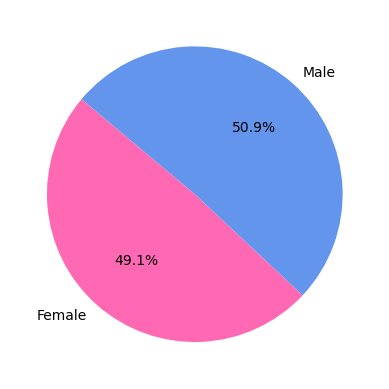

In [ ]:
sex_distrib = Counter(rm_top_applicants['cand_gender'])
sex_distrib_df = pd.DataFrame(sex_distrib.items(), columns=['cand_gender', 'Count'])

labels = sex_distrib_df['cand_gender']
sizes = sex_distrib_df['Count']

colors=custom_palette
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=custom_palette)

By considering the whole dataset as well as just the one with the top applicants, we can see that the distribution between male and female candidates is almost perfectly equal

### 3. Domicile Region

In [ ]:
unique_values = rm_df['cand_domicile_region'].unique()
print("Unique values in canidates domicile region column:", unique_values)

Unique values in canidates domicile region column: ['VENETO' 'LOMBARDIA' 'EMILIA ROMAGNA' 'TRENTINO ALTO ADIGE' 'PIEMONTE'
 'TOSCANA' 'MARCHE' 'PUGLIA' 'MOLISE' 'ABRUZZO' 'FRIULI VENEZIA GIULIA'
 'UMBRIA' 'LAZIO' 'LIGURIA' 'BASILICATA' 'SICILIA' 'CAMPANIA'
 "VALLE D'AOSTA" 'SARDEGNA' 'CALABRIA' 'Not disclosed']


In [ ]:
# Count occurrences of each region in percentage
region_counts = rm_df['cand_domicile_region'].value_counts(normalize=True) * 100
print("Percentage distribution of domicile regions: \n", region_counts)

Percentage distribution of domicile regions: 
 cand_domicile_region
LOMBARDIA                32.819914
PIEMONTE                 12.465241
VENETO                   11.851205
EMILIA ROMAGNA           11.153954
LAZIO                     7.864623
TOSCANA                   6.018897
ABRUZZO                   2.858265
FRIULI VENEZIA GIULIA     2.808646
CAMPANIA                  2.629811
MARCHE                    2.171868
TRENTINO ALTO ADIGE       1.714959
PUGLIA                    1.695318
LIGURIA                   1.523202
UMBRIA                    0.787186
SICILIA                   0.545810
MOLISE                    0.394885
SARDEGNA                  0.316838
VALLE D'AOSTA             0.181937
BASILICATA                0.127149
CALABRIA                  0.059956
Not disclosed             0.010337
Name: proportion, dtype: float64


/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_975/3027683764.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_counts.index, y=region_counts.values, palette="viridis")


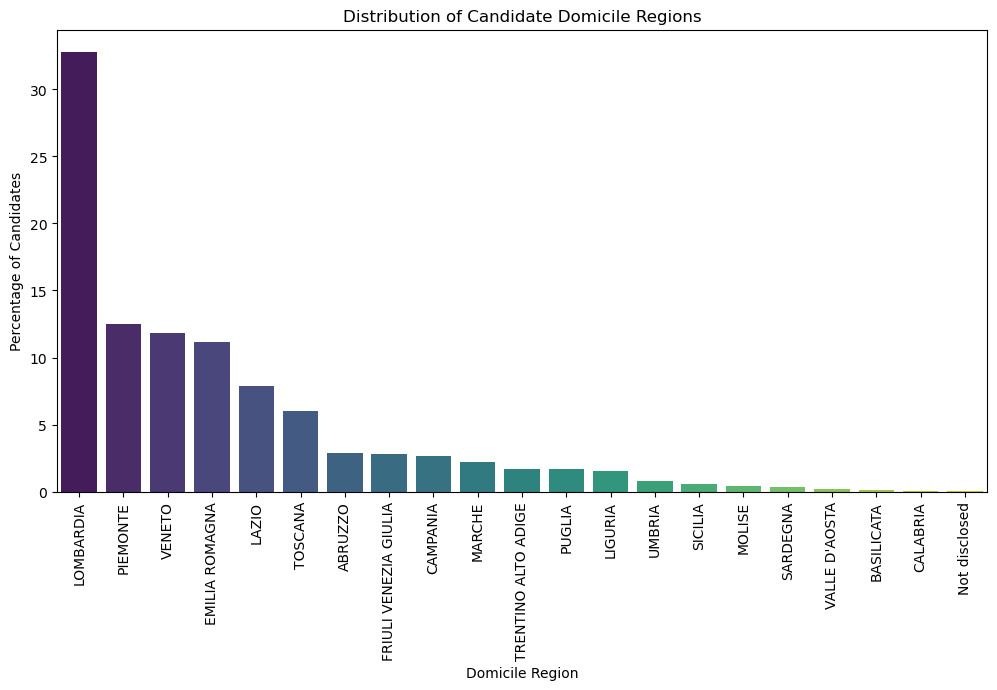

In [ ]:
# Plot the frequency of each domicile region
plt.figure(figsize=(12, 6))
sns.barplot(x=region_counts.index, y=region_counts.values, palette="viridis")

plt.xlabel("Domicile Region")
plt.ylabel("Percentage of Candidates")
plt.title("Distribution of Candidate Domicile Regions")
plt.xticks(rotation=90)  
plt.show()


From the plot we can see that the most candidates come from the Lombardy region and in general the ones that are from south of Italy are less

### 3.1 Domicile Region of the Top Applicants

In [ ]:
# Count occurrences of each region in percentage
region_counts_top = rm_top_applicants['cand_domicile_region'].value_counts(normalize=True) * 100
print("Percentage distribution of domicile regions (top applicants): \n", region_counts_top)

Percentage distribution of domicile regions (top applicants): 
 cand_domicile_region
LOMBARDIA                30.529951
PIEMONTE                 11.863761
VENETO                   11.215910
EMILIA ROMAGNA           10.734786
LAZIO                     7.807550
TOSCANA                   5.930690
CAMPANIA                  3.741813
ABRUZZO                   3.041562
PUGLIA                    2.924854
FRIULI VENEZIA GIULIA     2.746219
MARCHE                    2.243658
TRENTINO ALTO ADIGE       1.702989
LIGURIA                   1.598190
SICILIA                   1.183756
UMBRIA                    0.876504
SARDEGNA                  0.709777
MOLISE                    0.526378
BASILICATA                0.266762
VALLE D'AOSTA             0.185781
CALABRIA                  0.159581
Not disclosed             0.009527
Name: proportion, dtype: float64


/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_975/578743900.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_counts_top.index, y=region_counts_top.values, palette="viridis")


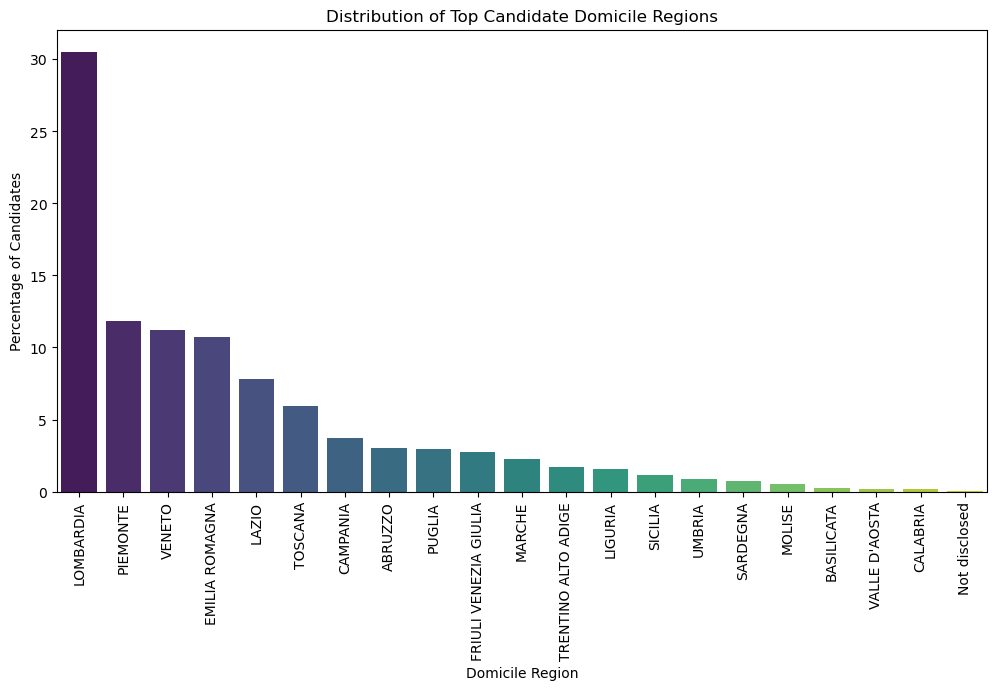

In [ ]:

plt.figure(figsize=(12, 6))
sns.barplot(x=region_counts_top.index, y=region_counts_top.values, palette="viridis")

plt.xlabel("Domicile Region")
plt.ylabel("Percentage of Candidates")
plt.title("Distribution of Top Candidate Domicile Regions")
plt.xticks(rotation=90)  
plt.show()

By checking the distribution of the domicile region of the candidates considering the whole dataset and the top ones only, we can see that most of the people come from North Italy. Lombardia is the top region, followed by Piemonte and Veneto

### 4. Dominicile Province

In [ ]:
unique_values = rm_df['cand_domicile_province'].unique()
print("Unique values in canidates domicile province column:", unique_values)

Unique values in canidates domicile province column: ['VE' 'BS' 'PR' 'RE' 'TN' 'BO' 'MI' 'TO' 'PI' 'CO' 'CR' 'MB' 'SI' 'PU'
 'TA' 'CB' 'CH' 'MO' 'PD' 'GO' 'FE' 'PG' 'BG' 'PV' 'VR' 'VI' 'LT' 'RM'
 'GE' 'NO' 'AL' 'TV' 'PO' 'AT' 'SO' 'PZ' 'AN' 'PC' 'BR' 'PT' 'FI' 'RO'
 'AQ' 'AR' 'BZ' 'LI' 'VC' 'MS' 'BI' 'PA' 'CN' 'Not disclosed' 'MN' 'BA'
 'LC' 'UD' 'ME' 'FR' 'FC' 'PN' 'AO' 'AV' 'SV' 'LU' 'VA' 'SA' 'BL' 'CT'
 'TS' 'LO' 'CE' 'MC' 'EN' 'CL' 'TE' 'VB' 'LE' 'VT' 'FM' 'RN' 'FG' 'RI'
 'AP' 'PE' 'SP' 'BN' 'SR' 'CA' 'SS' 'RC' 'RG' 'IS' 'RA' 'BT' 'MT' 'IM'
 'TP' 'SU' 'TR' 'AG' 'GR' 'CS' 'CZ' 'OR' 'NU' 'VV' 'SC' 'KR']


In [ ]:
# Count occurrences of each region in percentage
province_counts = rm_df['cand_domicile_province'].value_counts(normalize=True) * 100
print("Percentage distribution of domicile province: \n", province_counts)

Percentage distribution of domicile province: 
 cand_domicile_province
MI    10.810755
TO     7.034537
RM     5.485492
BG     4.551516
BS     3.992785
        ...    
CZ     0.009820
VV     0.007753
SC     0.005169
EN     0.002067
KR     0.001034
Name: proportion, Length: 108, dtype: float64


/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_975/1383785980.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=province_counts.index, y=province_counts.values, palette="viridis")


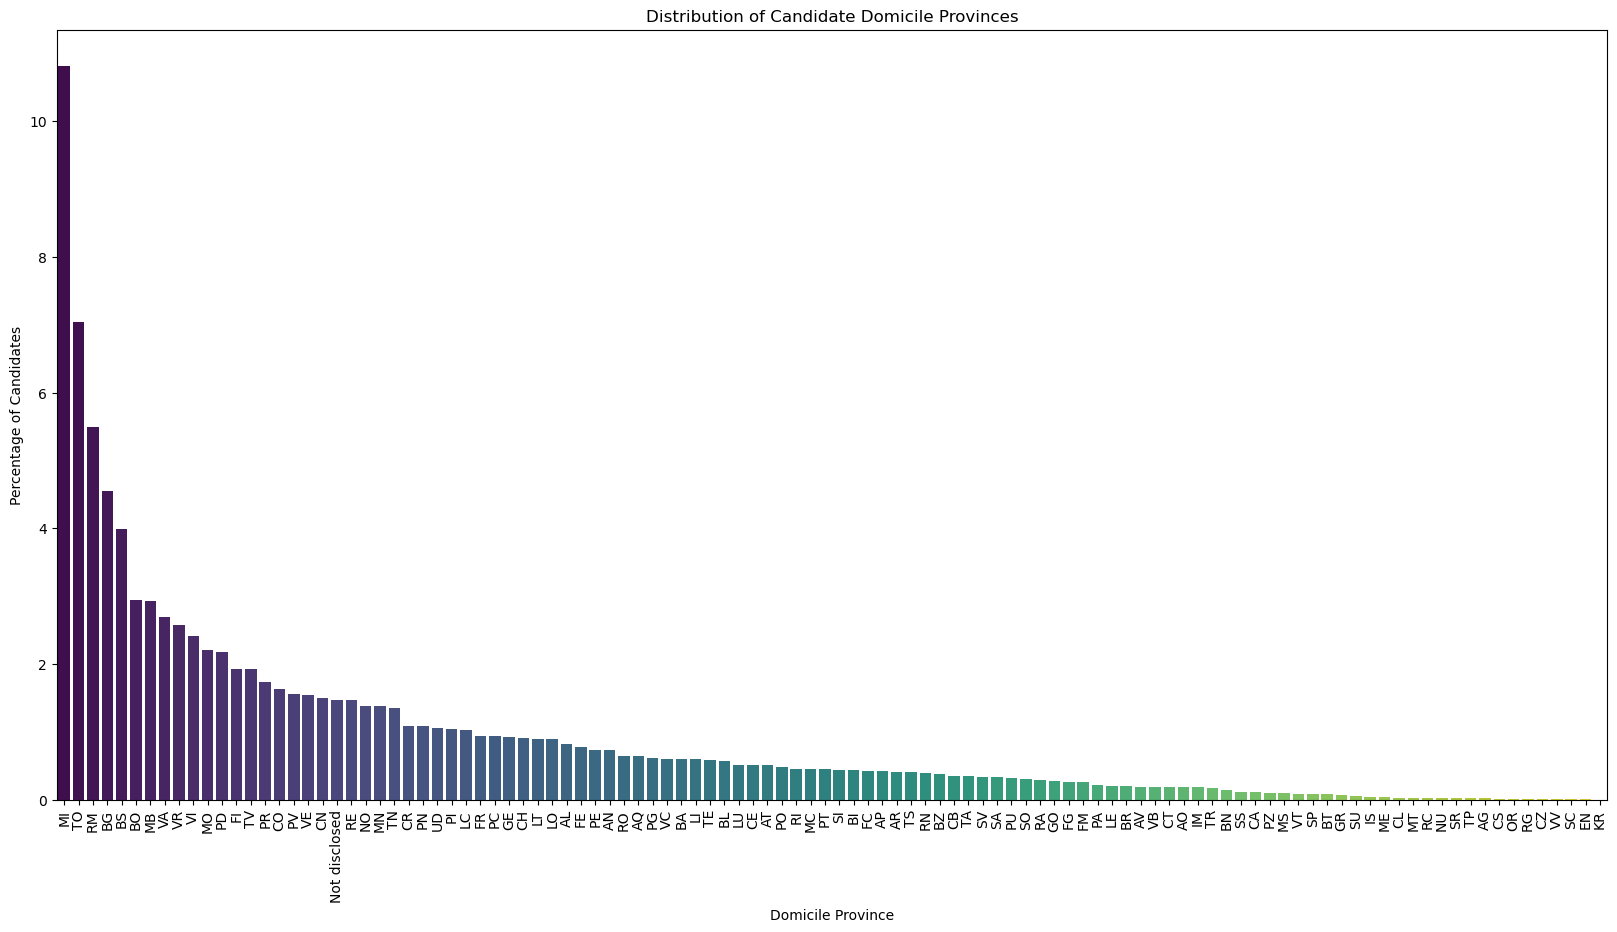

In [ ]:
# Plot the frequency of each domicile region
plt.figure(figsize=(20, 10))
sns.barplot(x=province_counts.index, y=province_counts.values, palette="viridis")

# Customize the plot
plt.xlabel("Domicile Province")
plt.ylabel("Percentage of Candidates")
plt.title("Distribution of Candidate Domicile Provinces")
plt.xticks(rotation=90)  
plt.show()


### 4.1. Domicile Province for the Top Applicants

In [ ]:
# Count occurrences of each region in percentage
province_counts_top = rm_top_applicants['cand_domicile_province'].value_counts(normalize=True) * 100
print("Percentage distribution of domicile province: \n", province_counts_top)

Percentage distribution of domicile province: 
 cand_domicile_province
MI    10.020245
TO     6.714303
RM     5.413838
BG     4.232464
BS     3.727522
        ...    
VV     0.026200
CZ     0.023818
EN     0.007145
SC     0.004764
KR     0.004764
Name: proportion, Length: 108, dtype: float64


/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_975/219218898.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=province_counts_top.index, y=province_counts_top.values, palette="viridis")


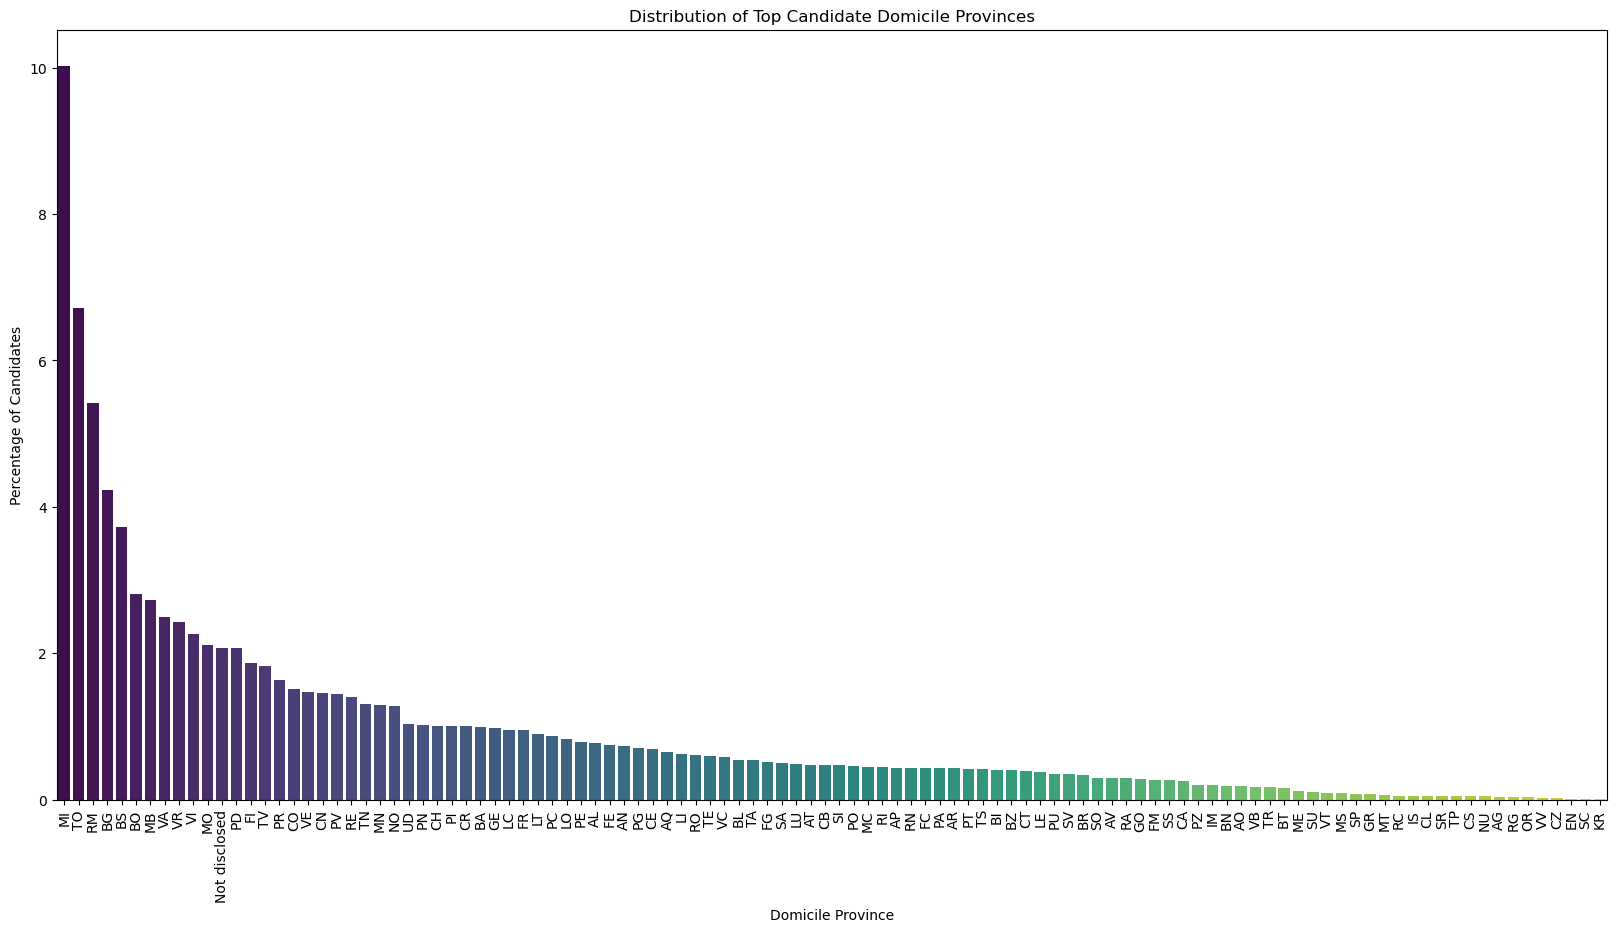

In [ ]:
# Plot the frequency of each domicile region
plt.figure(figsize=(20, 10))
sns.barplot(x=province_counts_top.index, y=province_counts_top.values, palette="viridis")

# Customize the plot
plt.xlabel("Domicile Province")
plt.ylabel("Percentage of Candidates")
plt.title("Distribution of Top Candidate Domicile Provinces")
plt.xticks(rotation=90)  
plt.show()


By checking the distribution of the domicile province of the candidates considering the whole dataset and the top ones only, we can see that most of the people come from North Italy, Milan is the city with the highest percentage of candidates. In general, we can see that North Italy has a higher results than South

### 5. Job Work Province

In [ ]:
# Count occurrences of each region in percentage
job_province_counts = rm_df['job_work_province'].value_counts(normalize=True) * 100
print("Percentage distribution of job province: \n", job_province_counts)

Percentage distribution of job province: 
 job_work_province
MI               17.443688
Not disclosed    12.328788
RM                6.075235
TO                6.047324
BG                4.418682
                   ...    
CS                0.003101
OG                0.001034
CZ                0.001034
OR                0.000517
EN                0.000517
Name: proportion, Length: 108, dtype: float64


/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_975/986344537.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=job_province_counts.index, y=job_province_counts.values, palette="viridis")


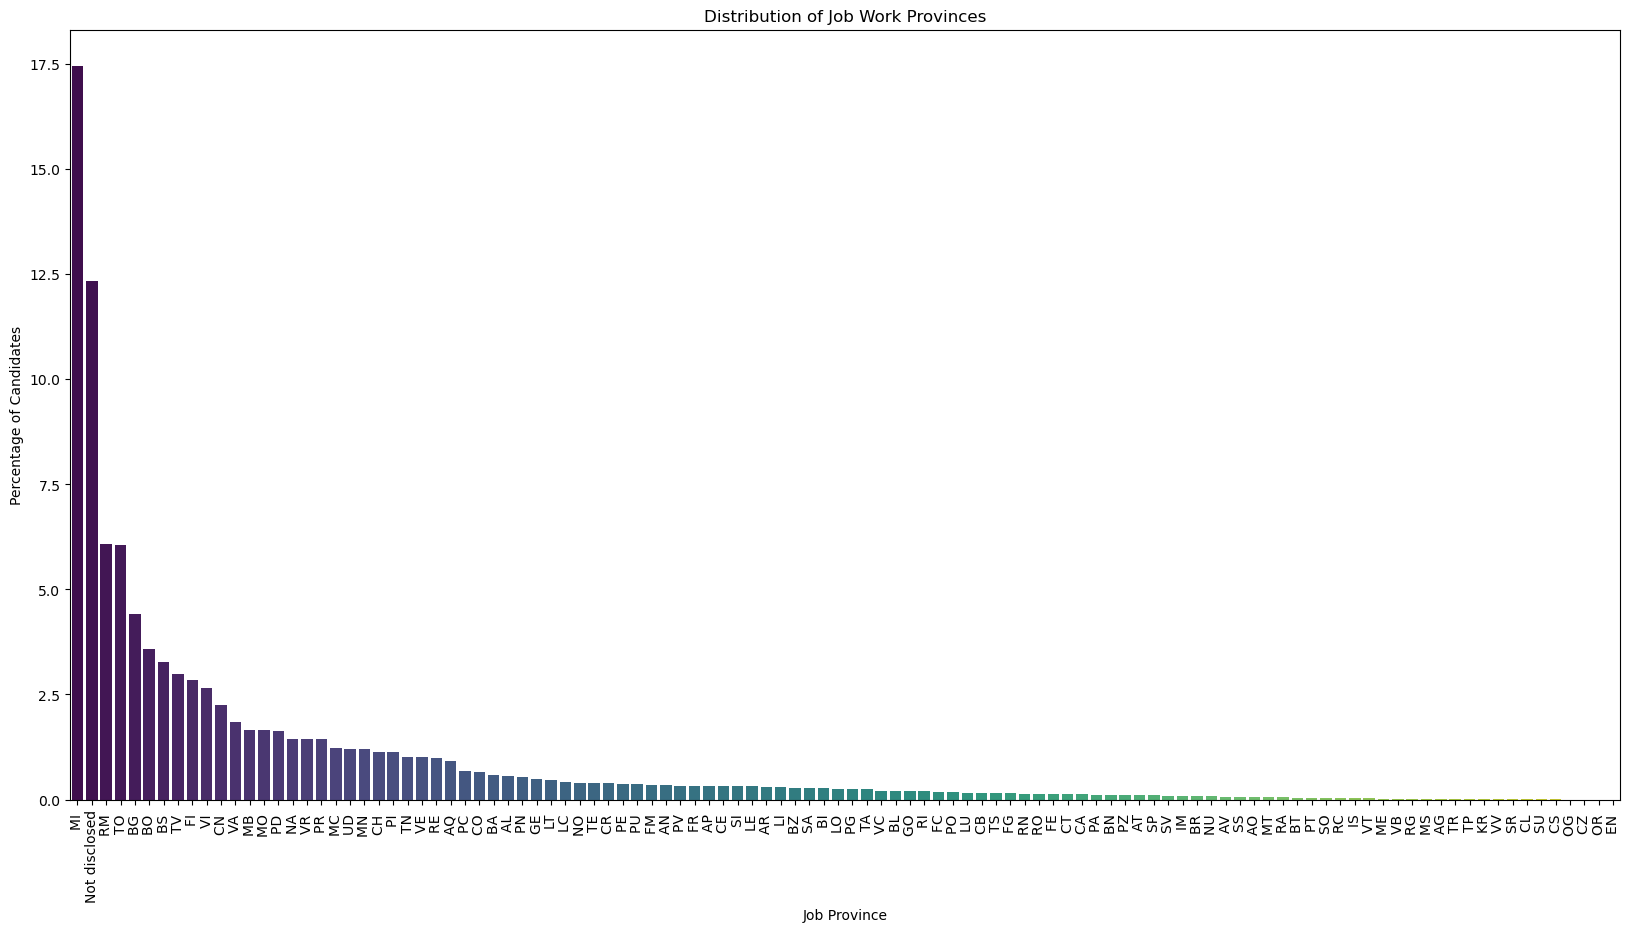

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x=job_province_counts.index, y=job_province_counts.values, palette="viridis")

plt.xlabel("Job Province")
plt.ylabel("Percentage of Candidates")
plt.title("Distribution of Job Work Provinces")
plt.xticks(rotation=90)  
plt.show()

### 5.1. Job Work Province for the Top Applicants

In [ ]:
# Count occurrences of each region in percentage
job_province_counts_top = rm_top_applicants['job_work_province'].value_counts(normalize=True) * 100
print("Percentage distribution of job province: \n", job_province_counts_top)

Percentage distribution of job province: 
 job_work_province
MI               16.041443
Not disclosed    12.852209
RM                5.978326
TO                5.883053
BG                4.180064
                   ...    
CL                0.007145
SR                0.004764
SU                0.002382
CZ                0.002382
OG                0.002382
Name: proportion, Length: 106, dtype: float64


/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_975/1592946541.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=job_province_counts_top.index, y=job_province_counts_top.values, palette="viridis")


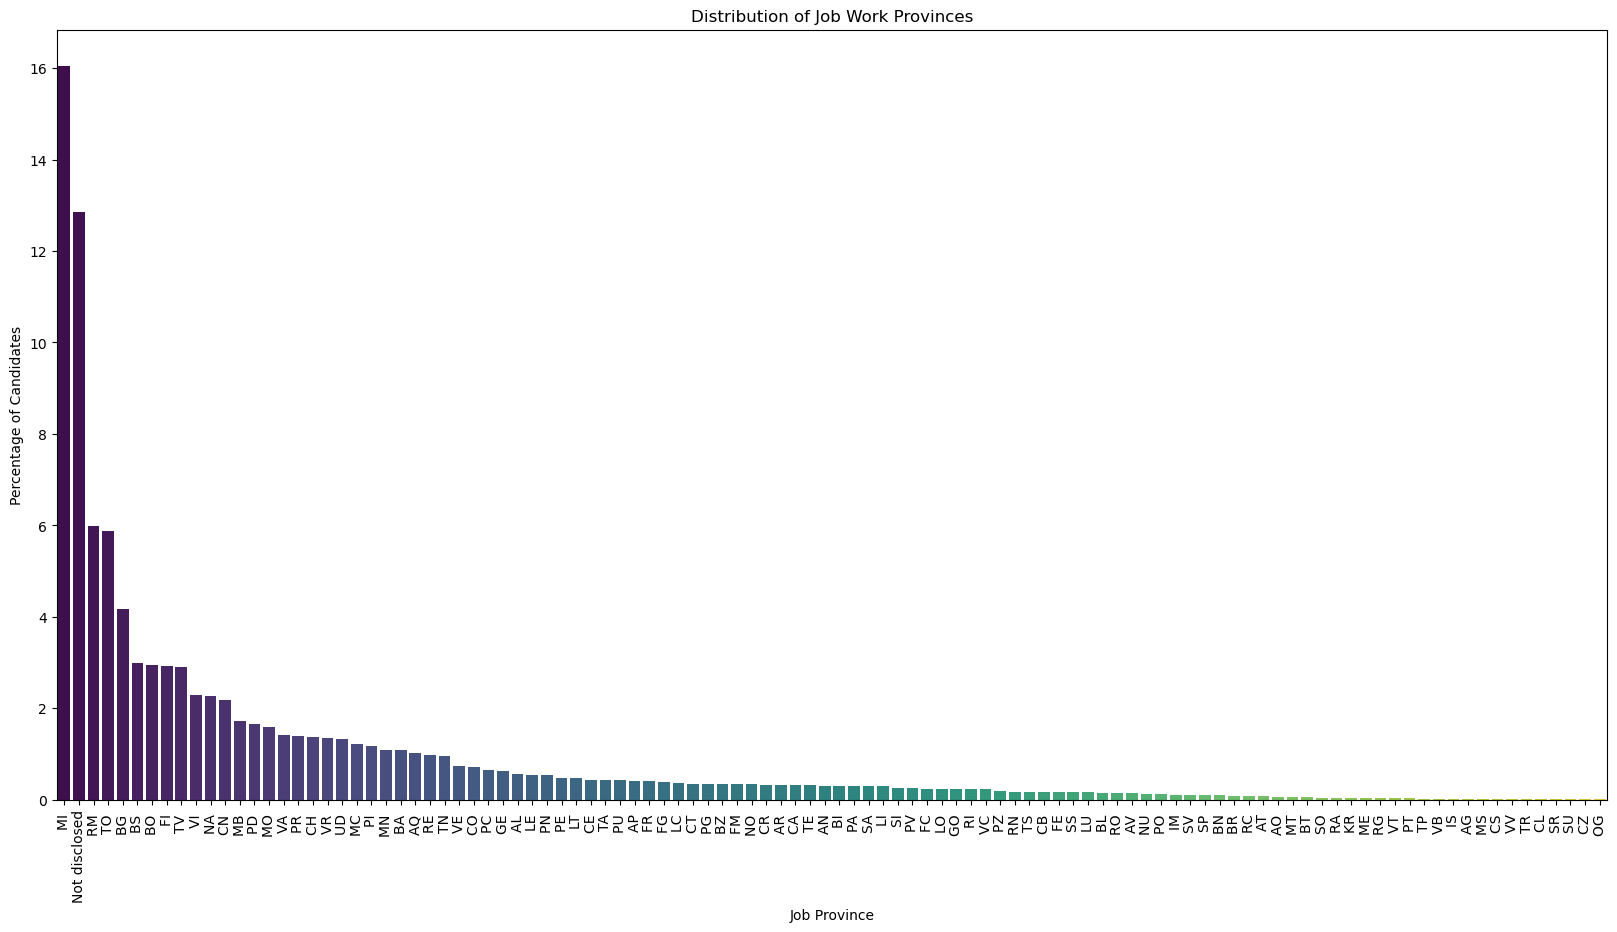

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x=job_province_counts_top.index, y=job_province_counts_top.values, palette="viridis")

plt.xlabel("Job Province")
plt.ylabel("Percentage of Candidates")
plt.title("Distribution of Job Work Provinces")
plt.xticks(rotation=90)  
plt.show()

By checking the distribution of the Job province of the candidates considering the whole dataset and the top ones only, we can see that most of the people work in North Italy, Milan is the city with the highest percentage of candidates. In general, we can see that North Italy has a higher results than South. However, a lot of people didn't specify their job province, therefore the column is named as "Not disclosed" and is the 2nd highest

### 6. Education

In [ ]:
print(f"There are {len(rm_df['cand_education'].unique())} different  values:\n {rm_df['cand_education'].unique()} \n")
     

There are 1678 different  values:
 ["Master's Degree: Economics for arts, culture and communication"
 'Not disclosed' 'Diploma / Academy: Accountant and programmer' ...
 "Bachelor's Degree: Communication Sciences (L-20); Master's Degree: Entertainment Sciences and Multimedia Production (LM-65)"
 "Master's Degree: Linguistics (LM-39); University Master's Degree: Humanistic/Social Master's Degree"
 'Qualification / Certificate: Sales clerk; Qualification / Certificate: Office operator; Qualification / Certificate: Tourism company operator; Diploma / Academy: Accounting'] 



In [ ]:
study_areas_counts = Counter(rm_df['cand_education'])

study_areas_counts_df = pd.DataFrame(study_areas_counts.items(), columns=['cand_education', 'Count'])
study_areas_counts_df = study_areas_counts_df.sort_values(by='Count', ascending=False)

study_areas_counts_df.head(10)

,cand_education,Count
1,Not disclosed,122829
5,Middle School diploma,5464
3,Diploma / Academy: Accounting,4683
33,Diploma / Academy: Scientific high school,2607
25,Diploma / Academy: Surveyor,1549
74,Higher Technical Institute (ITS): Other,1398
4,Diploma / Academy: Business Administration,1334
24,Diploma / Academy: Linguistic high school,1271
47,Diploma / Academy: Expert in Electronics and E...,1003
28,Diploma / Academy: Service technician for food...,968


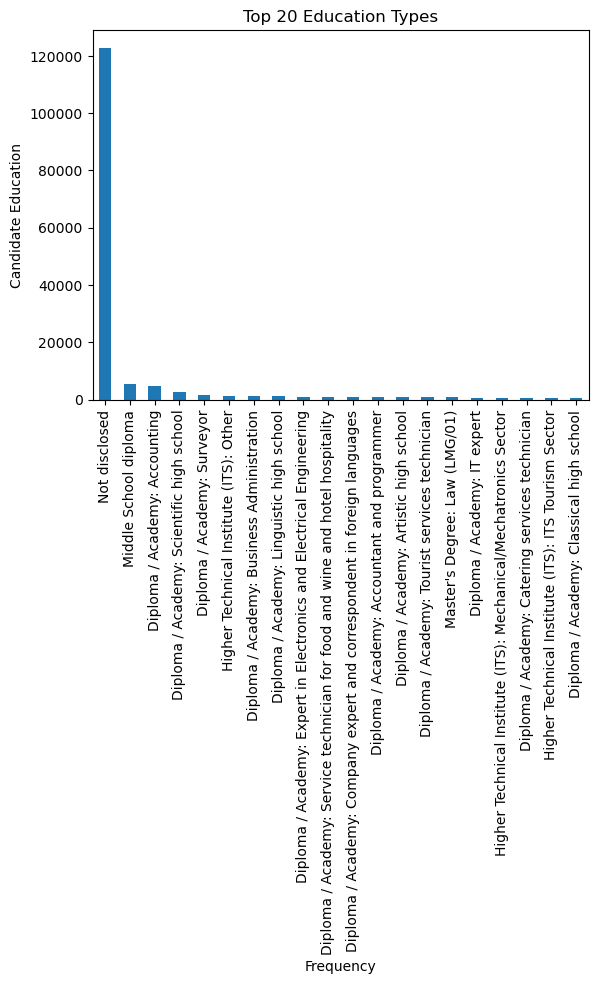

In [ ]:
study_areas_counts_df.head(20).plot(x='cand_education', y='Count', kind='bar', legend=False)
plt.title('Top 20 Education Types')
plt.xlabel('Frequency')
plt.ylabel('Candidate Education')
plt.show()

### 6.1 Education of the Top Applicants

In [ ]:
study_areas_counts_top = Counter(rm_top_applicants['cand_education'])

study_areas_counts_df_top = pd.DataFrame(study_areas_counts_top.items(), columns=['cand_education', 'Count'])
study_areas_counts_df_top = study_areas_counts_df_top.sort_values(by='Count', ascending=False)

study_areas_counts_df_top.head(10)

,cand_education,Count
1,Not disclosed,26240
5,Middle School diploma,1150
3,Diploma / Academy: Accounting,1038
33,Diploma / Academy: Scientific high school,589
25,Diploma / Academy: Surveyor,353
74,Higher Technical Institute (ITS): Other,314
4,Diploma / Academy: Business Administration,294
24,Diploma / Academy: Linguistic high school,274
47,Diploma / Academy: Expert in Electronics and E...,231
2,Diploma / Academy: Accountant and programmer,214


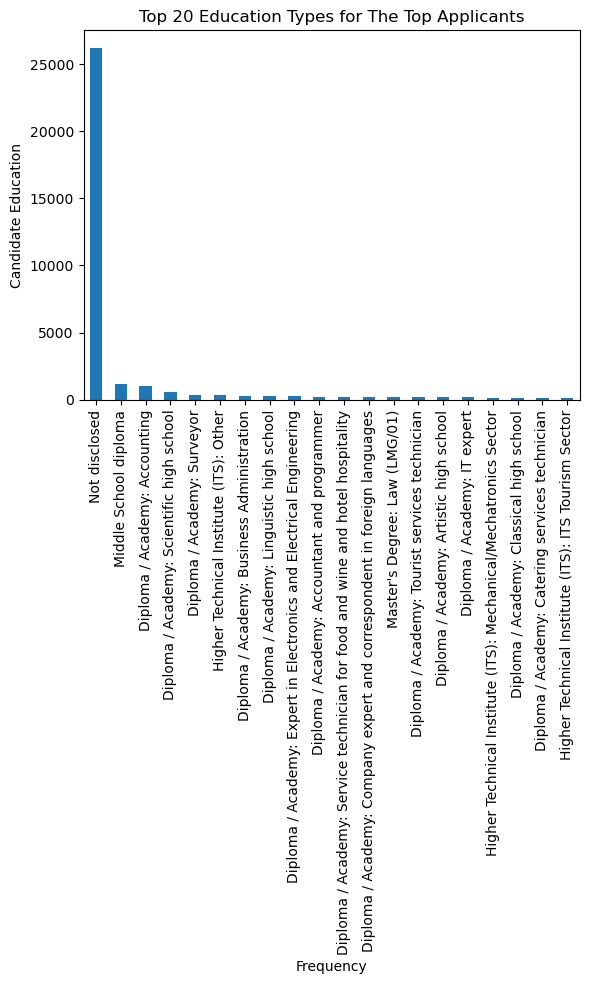

In [ ]:
study_areas_counts_df_top.head(20).plot(x='cand_education', y='Count', kind='bar', legend=False)
plt.title('Top 20 Education Types for The Top Applicants')
plt.xlabel('Frequency')
plt.ylabel('Candidate Education')
plt.show()

From both of the plots we can see that most of the people haven't specified their education level. However, Middle School Diploma has the 2nd highest result, which demonstrates that most of the candidates have this level

# Explore and plot with 2 features

### 1. Job contract type vs gender


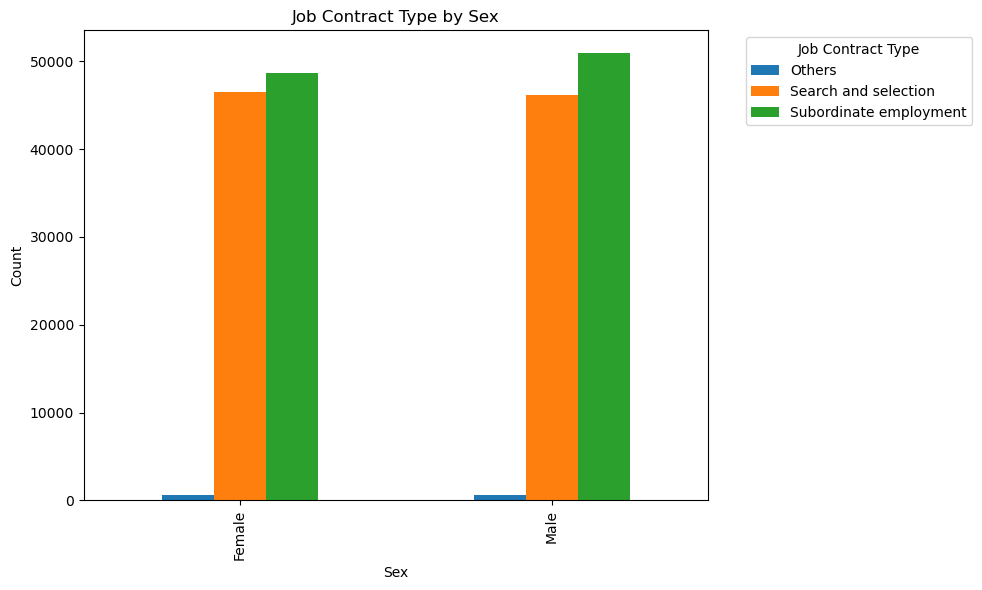

In [ ]:
pivot = rm_df.pivot_table(index='cand_gender', columns='job_contract_type', aggfunc='size', fill_value=0)

pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Job Contract Type by Sex')
plt.ylabel('Count')
plt.xlabel('Sex')
plt.legend(title='Job Contract Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

From the plot we can see that there is almost no difference between the different contract types offred to both males and females. For both genders, most of the people have received subordinate employment. For men the count is slightly higher. Big discrepancy gap cannot be indicated

### 2. Job contract type vs Age

/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_975/3021210932.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = rm_df.pivot_table(index='cand_age_bucket', columns='job_contract_type', aggfunc='size', fill_value=0)


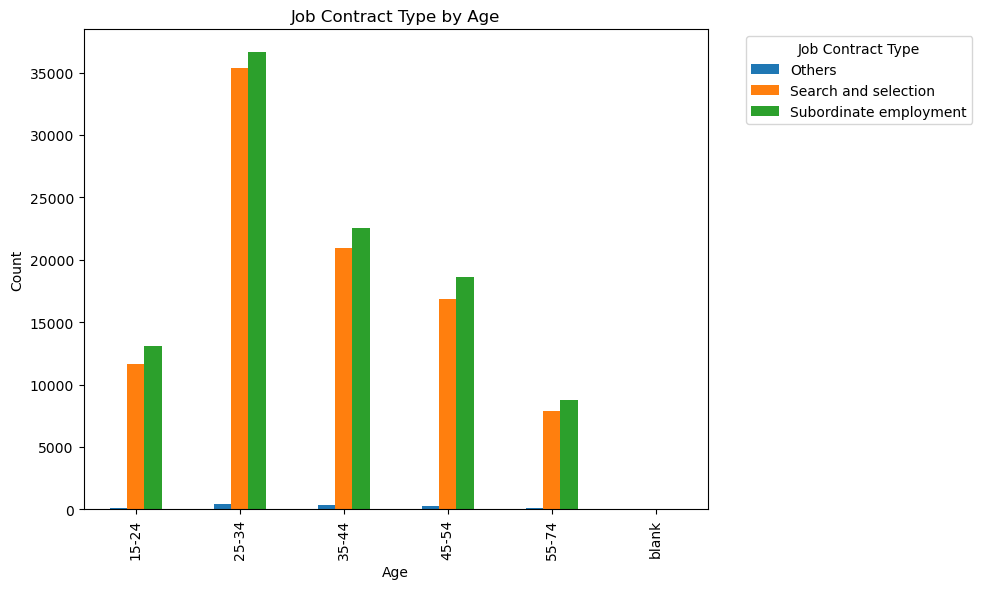

In [ ]:
pivot = rm_df.pivot_table(index='cand_age_bucket', columns='job_contract_type', aggfunc='size', fill_value=0)

pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Job Contract Type by Age')
plt.ylabel('Count')
plt.xlabel('Age')
plt.legend(title='Job Contract Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The largest age group of people that received any kind of job contract is 25-34 year olds, with highest number of Subordinate employment, followed by 35-44 y, 45-54, 15-24 and finally 55-74 year olds. The general trend is that most of the people get subordinate employment, followed by Search and selection, and then any other kind. 

### 3. Job Sector vs Gender

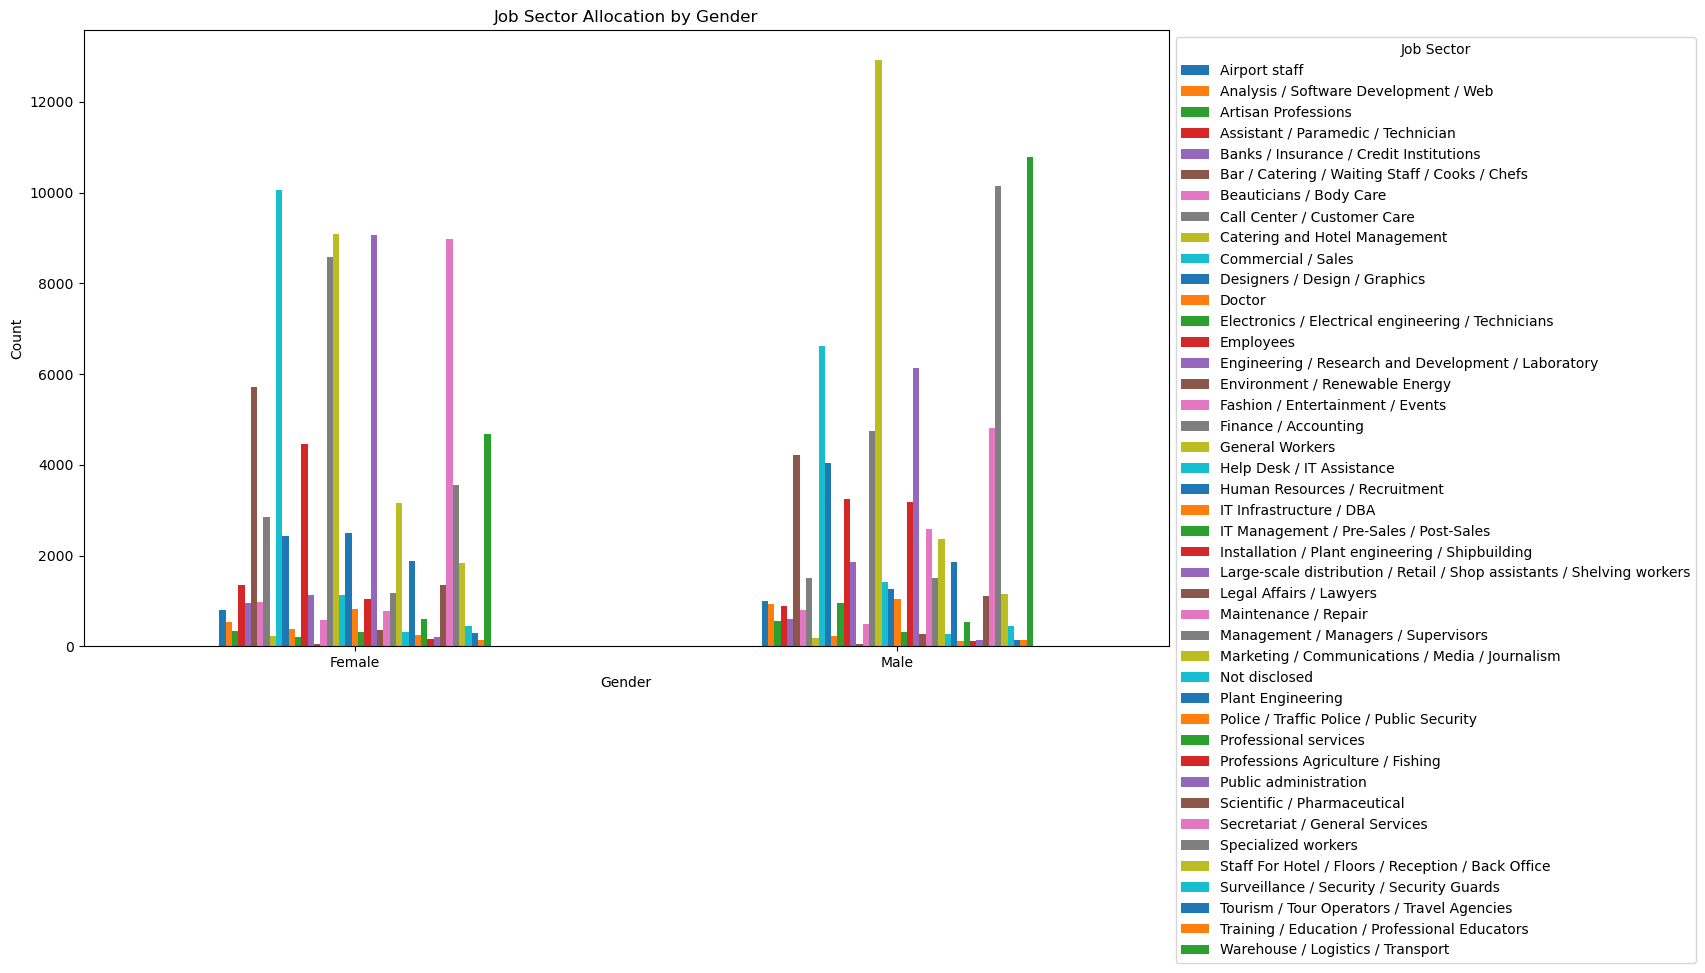

job_sector   Airport staff  Analysis / Software Development / Web  \
cand_gender                                                         
Female                 793                                    527   
Male                  1001                                    923   

job_sector   Artisan Professions  Assistant / Paramedic / Technician  \
cand_gender                                                            
Female                       347                                1359   
Male                         562                                 897   

job_sector   Banks / Insurance / Credit Institutions  \
cand_gender                                            
Female                                           951   
Male                                             598   

job_sector   Bar / Catering / Waiting Staff / Cooks / Chefs  \
cand_gender                                                   
Female                                                 5715   
Male                

In [ ]:
# Count the occurrences of each job sector per gender
job_sector_counts = rm_df.groupby(["cand_gender", "job_sector"]).size().unstack(fill_value=0)

job_sector_counts.plot(kind="bar", figsize=(14, 8))
plt.title("Job Sector Allocation by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Job Sector", bbox_to_anchor=(1, 1))
plt.show()

print(job_sector_counts)



### Top 5 job sectors by gender

In [ ]:
# Count occurrences of each job sector per gender
job_sector_counts = rm_df.groupby(["cand_gender", "job_sector"]).size().reset_index(name="count")

# Get the top 5 job sectors for each gender
top5_job_sectors = job_sector_counts.groupby("cand_gender").apply(lambda x: x.nlargest(5, "count")).reset_index(drop=True)

print(top5_job_sectors)


  cand_gender                                         job_sector  count
0      Female                                 Commercial / Sales  10046
1      Female                                    General Workers   9077
2      Female  Large-scale distribution / Retail / Shop assis...   9058
3      Female                     Secretariat / General Services   8983
4      Female                              Finance / Accounting    8569
5        Male                                    General Workers  12927
6        Male                  Warehouse / Logistics / Transport  10777
7        Male                                Specialized workers  10150
8        Male                                 Commercial / Sales   6624
9        Male  Large-scale distribution / Retail / Shop assis...   6133


/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_975/1007517330.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5_job_sectors = job_sector_counts.groupby("cand_gender").apply(lambda x: x.nlargest(5, "count")).reset_index(drop=True)


- We can see that the top 5 job sectors for Females are: Comercial/Sales, General workers, Large-scale distribution/Retail, Secretariat, Finance/Accounting
- For Males the top 5 job sectors are: General Workers, Warehouse/Logistics, Specialised Workers, Commercial/Sales, Large-scale distribution/Retail

### 4. Gender vs Match Rank

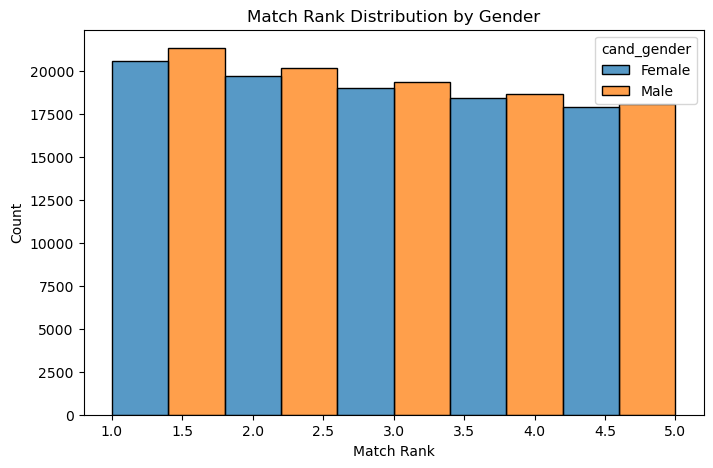

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(data=rm_df, x="match_rank", hue="cand_gender", multiple="dodge", bins=5)
plt.title("Match Rank Distribution by Gender")
plt.xlabel("Match Rank")
plt.ylabel("Count")
plt.show()

### 5. Age vs Match Rank

/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_975/504060205.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = rm_df.pivot_table(index='cand_age_bucket', columns='match_rank', aggfunc='size', fill_value=0)


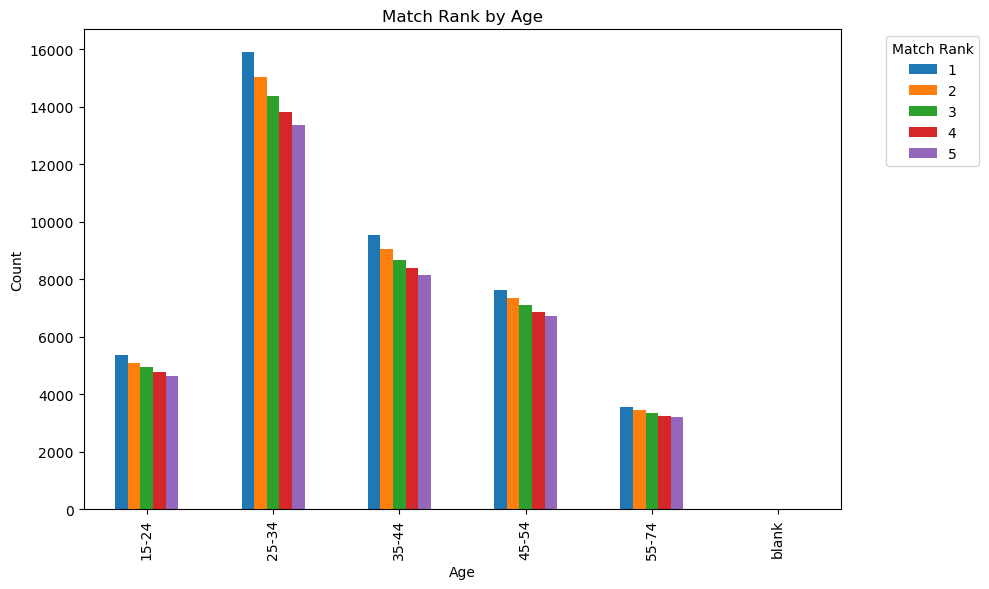

In [ ]:
pivot = rm_df.pivot_table(index='cand_age_bucket', columns='match_rank', aggfunc='size', fill_value=0)

pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Match Rank by Age')
plt.ylabel('Count')
plt.xlabel('Age')
plt.legend(title='Match Rank', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Again, the age group that is responsible for the most and highest scores is the 25-34 one

### 6. Candidate Domicile Region vs Match Rank

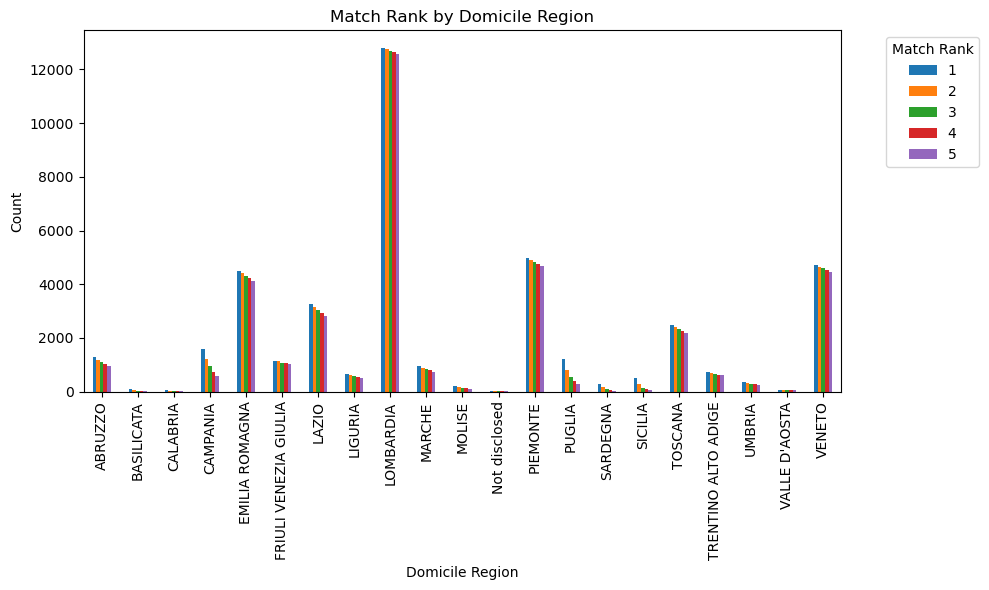

In [ ]:
pivot = rm_df.pivot_table(index='cand_domicile_region', columns='match_rank', aggfunc='size', fill_value=0)

pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Match Rank by Domicile Region')
plt.ylabel('Count')
plt.xlabel('Domicile Region')
plt.legend(title='Match Rank', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Again, the region that is responsible for the most counts and highest scores is Lombardia

### 7. Gender vs. Job Type Distribution (Offers vs. Orders)

The dataset contains the 5 best offers and orders:
Job positions published on the Adecco website and job positions managed internally

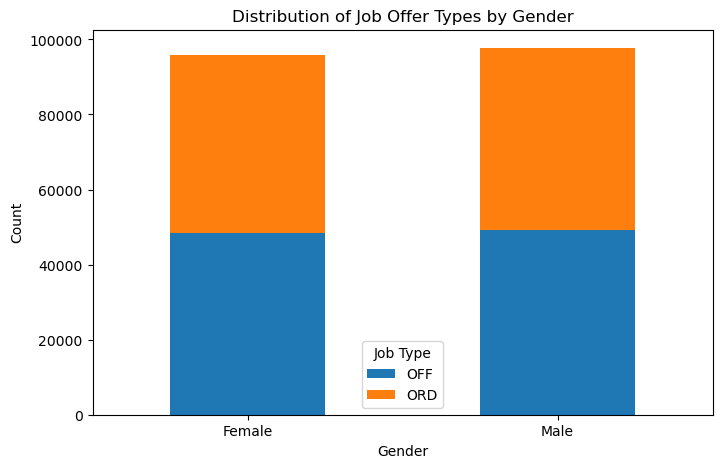

In [ ]:
# Extract job type prefix
rm_df["job_type"] = rm_df["job_id"].apply(lambda x: "OFF" if x.startswith("OFF_") else ("ORD" if x.startswith("ORD_") else None))

# Filter relevant job types
df_filtered = rm_df[rm_df["job_type"].notna()]

# Count occurrences per gender and job type
job_counts = df_filtered.groupby(["cand_gender", "job_type"]).size().unstack(fill_value=0)

job_counts.plot(kind="bar", stacked=True, figsize=(8, 5))
plt.title("Distribution of Job Offer Types by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Job Type")
plt.show()

The distribution between Offers and Orders for both males and females is almost equal. 

### 8. Match distribution of domicile and work province

In [ ]:
rm_df['match'] = rm_df['cand_domicile_province'] == rm_df['job_work_province']

match_percentage = rm_df['match'].mean() * 100
mismatch_percentage = 100 - match_percentage


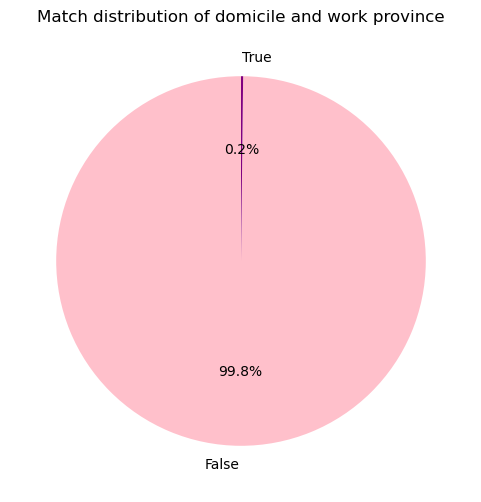

In [ ]:
plt.figure(figsize=(6, 6))
rm_df['match'].value_counts().plot.pie(autopct='%1.1f%%', colors=['pink', 'purple'], startangle=90)
plt.title("Match distribution of domicile and work province")
plt.ylabel("")  
plt.show()

### 8.1 Match distribution of domicile and work province for Top Applicants

In [ ]:
rm_top_applicants['match'] = rm_top_applicants['cand_domicile_province'] == rm_top_applicants['job_work_province']

match_percentage = rm_top_applicants['match'].mean() * 100
mismatch_percentage = 100 - match_percentage

/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_975/2717350295.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rm_top_applicants['match'] = rm_top_applicants['cand_domicile_province'] == rm_top_applicants['job_work_province']


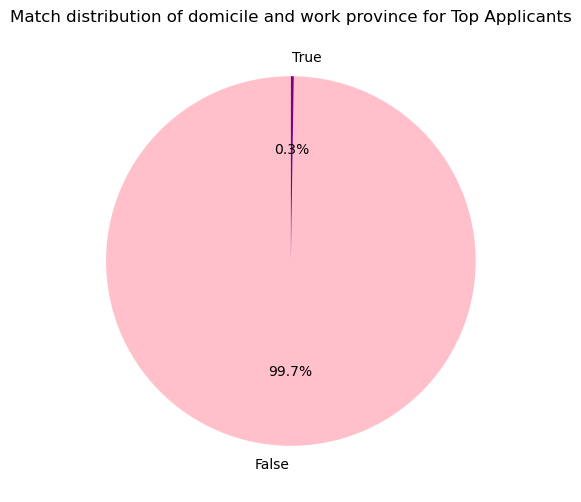

In [ ]:
plt.figure(figsize=(6, 6))
rm_top_applicants['match'].value_counts().plot.pie(autopct='%1.1f%%', colors=['pink', 'purple'], startangle=90)
plt.title("Match distribution of domicile and work province for Top Applicants")
plt.ylabel("")  
plt.show()

From the results we can see that most of the people have received an offer to work in a different province than the one they reside in 

### 9. Correlation Matrix

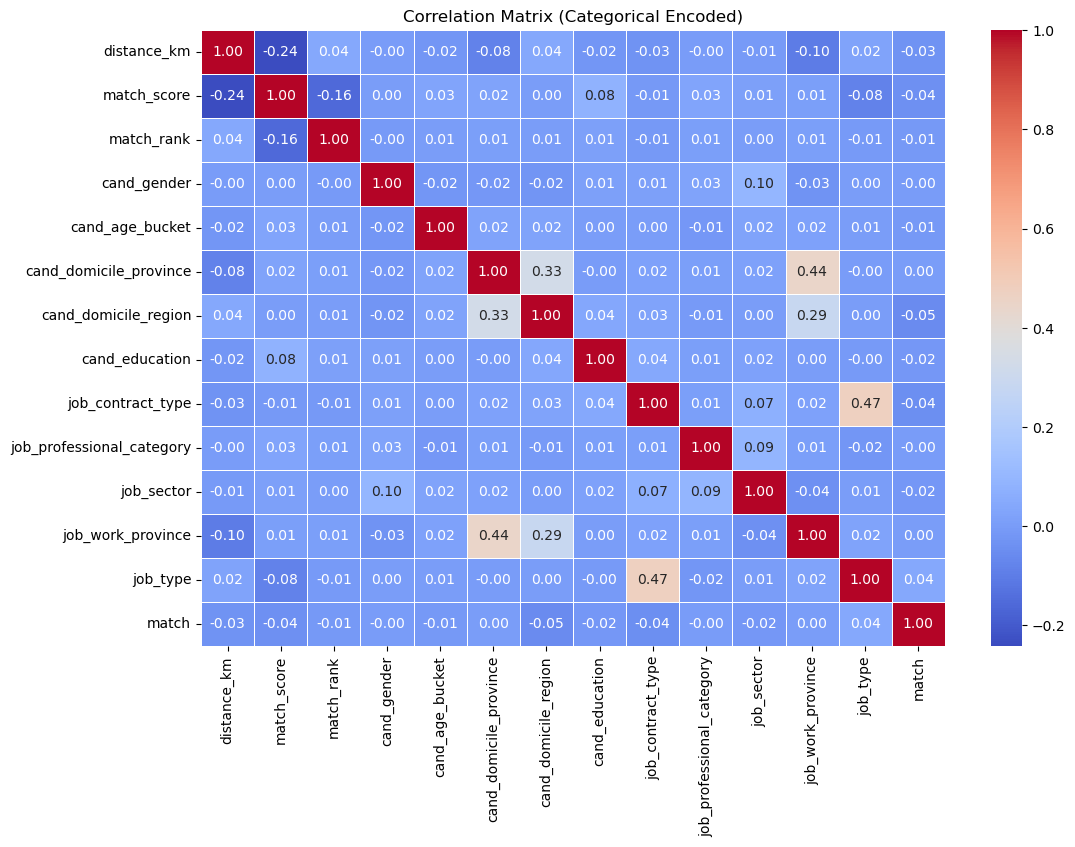

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns (excluding `cand_id` and `job_id` since they are unique identifiers)
categorical_columns = [
    "cand_gender", "cand_age_bucket", "cand_domicile_province",
    "cand_domicile_region", "cand_education", "job_contract_type",
    "job_professional_category", "job_sector", "job_work_province", "job_type"
]

# Apply Label Encoding for categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    rm_df[col] = le.fit_transform(rm_df[col])  
    label_encoders[col] = le

rm_df = rm_df.drop('cand_id', axis=1)
rm_df = rm_df.drop('job_id', axis=1)

# Compute the correlation matrix
correlation_matrix = rm_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Categorical Encoded)")
plt.show()


# AI Fairness 360 
## Bias Detection

In [ ]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

2025-03-24 13:55:30.887915: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
pip install 'aif360[inFairness]'


### 1. Detect Gender Bias w.r.t. match score

In [ ]:
# Retrieve the mapping from LabelEncoder
gender_label_mapping = {index: label for index, label in enumerate(label_encoders["cand_gender"].classes_)}

print("Label Encoding Mapping for gender:", gender_label_mapping)

Label Encoding Mapping for gender: {0: 'Female', 1: 'Male'}


In [ ]:
df = rm_df.copy()

# Ensure gender codes are integers
df["cand_gender"] = df["cand_gender"].astype(int)

# Define the target variable (match score threshold for fairness)
df["favorable_outcome"] = (df["match_score"] >= 80).astype(int)  # 1 if match_score ≥ 80

# Keep only necessary columns
df = df[["cand_gender", "favorable_outcome"]]

# Define protected attribute
protected_attribute = "cand_gender"  

In [ ]:
# Convert dataframe into AIF360 dataset
aif_dataset = StandardDataset(
    df,
    label_name="favorable_outcome",  # The target variable
    favorable_classes=[1],  # Match scores >= 80 are considered favorable
    protected_attribute_names=[protected_attribute],  
    privileged_classes=[[0]]  # Female (0) is privileged, male (1) is unprivileged
)

# Compute fairness metrics
metric = BinaryLabelDatasetMetric(
    aif_dataset, 
    privileged_groups=[{protected_attribute: 0}],  
    unprivileged_groups=[{protected_attribute: 1}]  
)



In [ ]:
print(f"Disparate Impact: {metric.disparate_impact()}")
print(f"Statistical Parity Difference: {metric.statistical_parity_difference()}")
print(f"Mean Difference: {metric.mean_difference()}")

Disparate Impact: 0.9966378609367027
Statistical Parity Difference: -0.0030056634406304683
Mean Difference: -0.0030056634406304683


1. Diasparate Impact: 
- measure whether the positive outcome rate (match score >= 80) is similar for unpriviledged (male) and privilidged (female) groups
- Score that equals 1 means that there is no bias, they are treated equally
- In our case, the result we have obtained is 0.996 -> almost 1 -> no bias
2. Statistical Parity Difference:
- measures the absolute difference in positive outcome rates between the unprivileged (male) and privileged (female) groups
- Score that equals to 0 means there is no bias
- In our case, the result we have obtained is: -0.003, very close to 0 meaning that gender has little to no effect on match score distribution
3. Mean Difference:
- Similar to SPD, but measured as a direct mean difference in positive outcomes
- Score that equals to 0 means there is no bias
- In our case, the result we have obtained is: -0.003, very close to 0 meaning that gender has little to no effect in avg match score outcomes


### 2. Detect Age Bias w.r.t. match score

In [ ]:
# Retrieve the mapping from LabelEncoder
age_label_mapping = {index: label for index, label in enumerate(label_encoders["cand_age_bucket"].classes_)}

print("Label Encoding Mapping for age:", age_label_mapping)

Label Encoding Mapping for age: {0: '15-24', 1: '25-34', 2: '35-44', 3: '45-54', 4: '55-74'}


In [ ]:
df = rm_df.copy()

# Ensure age bucket codes are integers
df["cand_age_bucket"] = df["cand_age_bucket"].astype(int)

# Define the target variable (match score threshold for fairness)
df["favorable_outcome"] = (df["match_score"] >= 80).astype(int)  # 1 if match_score ≥ 80

# Keep only necessary columns
df = df[["cand_age_bucket", "favorable_outcome"]]

In [ ]:
# Define privileged age group (25-34)
privileged_age = [1]  

# Convert dataframe into AIF360 dataset
aif_dataset = StandardDataset(
    df,
    label_name="favorable_outcome",
    favorable_classes=[1],  
    protected_attribute_names=["cand_age_bucket"],  
    privileged_classes=[privileged_age]  
)


In [ ]:
# Get all age groups except 25-34
all_ages = df["cand_age_bucket"].unique()
unprivileged_ages = [{"cand_age_bucket": r} for r in all_ages if r != 1]

# Store results in a dictionary
fairness_results = []

for age in unprivileged_ages:
    metric = BinaryLabelDatasetMetric(
        aif_dataset, 
        privileged_groups=[{"cand_age_bucket": 1}],  
        unprivileged_groups=[age]
    )
    
    fairness_results.append({
        "Age Bucket": age["cand_age_bucket"],
        "Disparate Impact": metric.disparate_impact(),
        "Statistical Parity Difference": metric.statistical_parity_difference()
    })


In [ ]:
print(fairness_results)

[{'Age Bucket': 4, 'Disparate Impact': 1.0304406971793534, 'Statistical Parity Difference': 0.026919872795473476}, {'Age Bucket': 2, 'Disparate Impact': 1.0070218581513424, 'Statistical Parity Difference': 0.006209697731568542}, {'Age Bucket': 3, 'Disparate Impact': 1.0211388861559054, 'Statistical Parity Difference': 0.018693925536663825}, {'Age Bucket': 0, 'Disparate Impact': 1.0082261010113216, 'Statistical Parity Difference': 0.007274655751895565}]


In [ ]:
fairness_df = pd.DataFrame(fairness_results)

fairness_df = fairness_df.fillna(0)

fairness_df = fairness_df.sort_values(by="Disparate Impact")

age_label_mapping = {
    0: '15-24', 1: '25-34', 2: '35-44', 3: '45-54', 4: '55-74'}

fairness_df["Age Bucket"] = fairness_df["Age Bucket"].map(age_label_mapping).fillna("Unknown Age")

/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_975/508195779.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Age Bucket", y="Disparate Impact", data=fairness_df, palette="coolwarm")


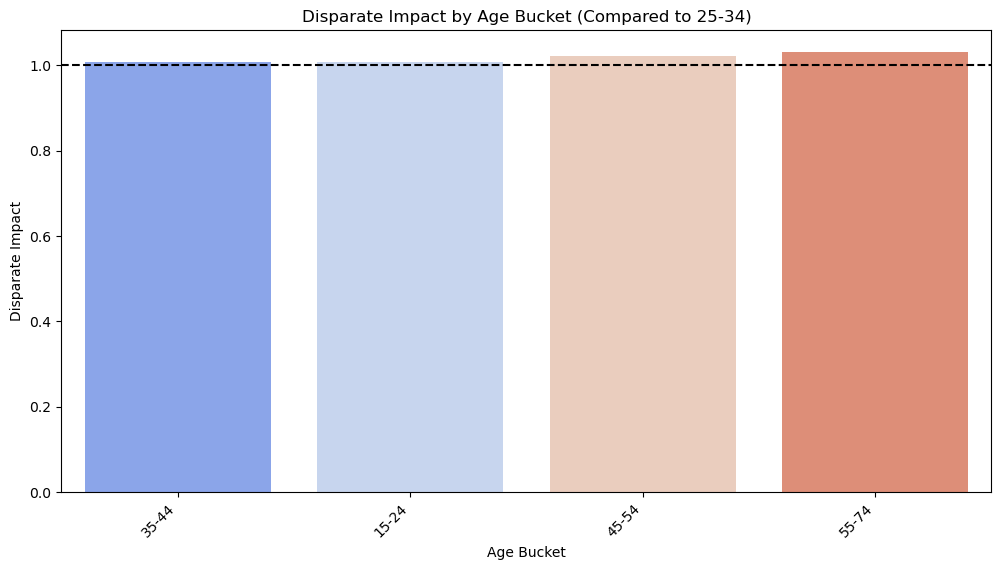

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Age Bucket", y="Disparate Impact", data=fairness_df, palette="coolwarm")
plt.axhline(y=1, color="black", linestyle="--")  
plt.xlabel("Age Bucket")
plt.ylabel("Disparate Impact")
plt.title("Disparate Impact by Age Bucket (Compared to 25-34)")
plt.xticks(rotation=45, ha="right")  
plt.show()

Looking at the results on the graph, we can notice that the disparate impact of all age groups compared to 25-34 is close to 1, meaning that there is minimal to zero bias 

/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_975/1195298802.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Age Bucket", y="Statistical Parity Difference", data=fairness_df, palette="coolwarm")


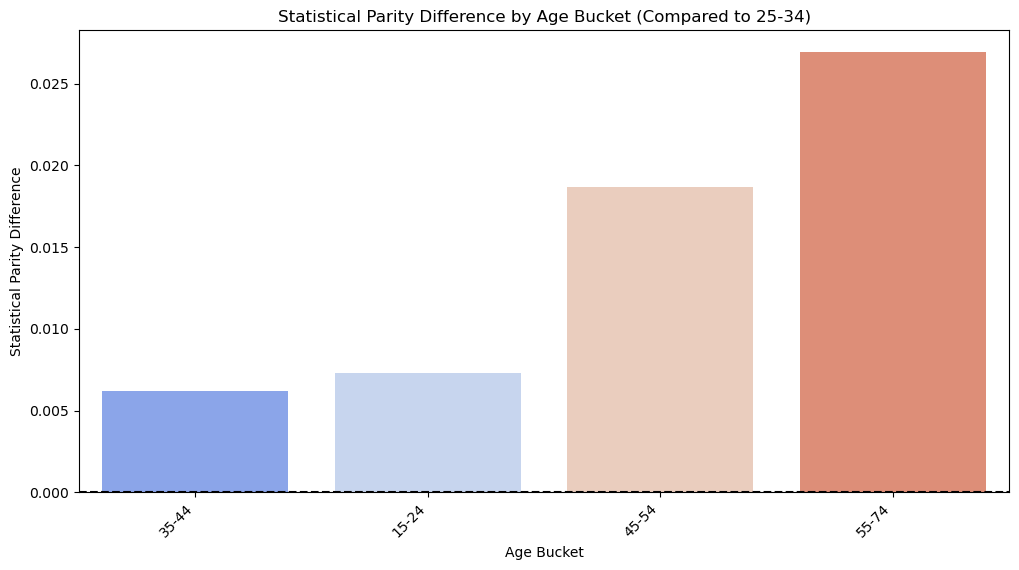

In [ ]:
fairness_df = fairness_df.sort_values(by="Statistical Parity Difference")

plt.figure(figsize=(12, 6))
sns.barplot(x="Age Bucket", y="Statistical Parity Difference", data=fairness_df, palette="coolwarm")
plt.axhline(y=0, color="black", linestyle="--")  
plt.xlabel("Age Bucket")
plt.ylabel("Statistical Parity Difference")
plt.title("Statistical Parity Difference by Age Bucket (Compared to 25-34)")
plt.xticks(rotation=45, ha="right")  
plt.show()

### 3. Detect Region Bias w.r.t. Match score

In [ ]:
# Retrieve the mapping from LabelEncoder
region_label_mapping = {index: label for index, label in enumerate(label_encoders["cand_domicile_region"].classes_)}

print("Label Encoding Mapping for Regions:", region_label_mapping)


Label Encoding Mapping for Regions: {0: 'ABRUZZO', 1: 'BASILICATA', 2: 'CALABRIA', 3: 'CAMPANIA', 4: 'EMILIA ROMAGNA', 5: 'FRIULI VENEZIA GIULIA', 6: 'LAZIO', 7: 'LIGURIA', 8: 'LOMBARDIA', 9: 'MARCHE', 10: 'MOLISE', 11: 'Not disclosed', 12: 'PIEMONTE', 13: 'PUGLIA', 14: 'SARDEGNA', 15: 'SICILIA', 16: 'TOSCANA', 17: 'TRENTINO ALTO ADIGE', 18: 'UMBRIA', 19: "VALLE D'AOSTA", 20: 'VENETO'}


In [ ]:
df = rm_df.copy()

df["cand_domicile_region"] = df["cand_domicile_region"].astype(int)

df["favorable_outcome"] = (df["match_score"] >= 80).astype(int)  # 1 if match_score ≥ 80

df = df[["cand_domicile_region", "favorable_outcome"]]

In [ ]:
# Define privileged region (Lombardia = 8)
privileged_region = [8]  

# Convert dataframe into AIF360 dataset
aif_dataset = StandardDataset(
    df,
    label_name="favorable_outcome",
    favorable_classes=[1],  
    protected_attribute_names=["cand_domicile_region"],  
    privileged_classes=[privileged_region]  
)


In [ ]:
# Get all regions except Lombardia
all_regions = df["cand_domicile_region"].unique()
unprivileged_regions = [{"cand_domicile_region": r} for r in all_regions if r != 8]

fairness_results = []

for region in unprivileged_regions:
    metric = BinaryLabelDatasetMetric(
        aif_dataset, 
        privileged_groups=[{"cand_domicile_region": 8}], 
        unprivileged_groups=[region]
    )
    
    fairness_results.append({
        "Region": region["cand_domicile_region"],
        "Disparate Impact": metric.disparate_impact(),
        "Statistical Parity Difference": metric.statistical_parity_difference()
    })


In [ ]:
print(fairness_results)

[{'Region': 20, 'Disparate Impact': 0.9394368146049057, 'Statistical Parity Difference': -0.05829604797841759}, {'Region': 4, 'Disparate Impact': 0.9103045571540517, 'Statistical Parity Difference': -0.08633776122377412}, {'Region': 17, 'Disparate Impact': 0.8591664718190251, 'Statistical Parity Difference': -0.13556153069308274}, {'Region': 12, 'Disparate Impact': 0.9567851455914006, 'Statistical Parity Difference': -0.04159713874937798}, {'Region': 16, 'Disparate Impact': 0.9121178257581942, 'Statistical Parity Difference': -0.08459237096969052}, {'Region': 9, 'Disparate Impact': 0.8111847504432516, 'Statistical Parity Difference': -0.1817470923203569}, {'Region': 13, 'Disparate Impact': 0.6622924199538619, 'Statistical Parity Difference': -0.3250657501023655}, {'Region': 10, 'Disparate Impact': 0.6363881583788265, 'Statistical Parity Difference': -0.3500003050761874}, {'Region': 0, 'Disparate Impact': 0.8380630388013128, 'Statistical Parity Difference': -0.15587497252551197}, {'Regi

In [ ]:
fairness_df = pd.DataFrame(fairness_results)

fairness_df = fairness_df.fillna(0)

fairness_df = fairness_df.sort_values(by="Disparate Impact")

region_label_mapping = {
    0: 'ABRUZZO', 1: 'BASILICATA', 2: 'CALABRIA', 3: 'CAMPANIA', 4: 'EMILIA ROMAGNA',
    5: 'FRIULI VENEZIA GIULIA', 6: 'LAZIO', 7: 'LIGURIA', 8: 'LOMBARDIA', 9: 'MARCHE',
    10: 'MOLISE', 11: 'Not disclosed', 12: 'PIEMONTE', 13: 'PUGLIA', 14: 'SARDEGNA',
    15: 'SICILIA', 16: 'TOSCANA', 17: 'TRENTINO ALTO ADIGE', 18: 'UMBRIA', 19: "VALLE D'AOSTA", 20: 'VENETO'
}

fairness_df["Region"] = fairness_df["Region"].map(region_label_mapping).fillna("Unknown Region")

/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_975/2540976744.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Region", y="Disparate Impact", data=fairness_df, palette="coolwarm")


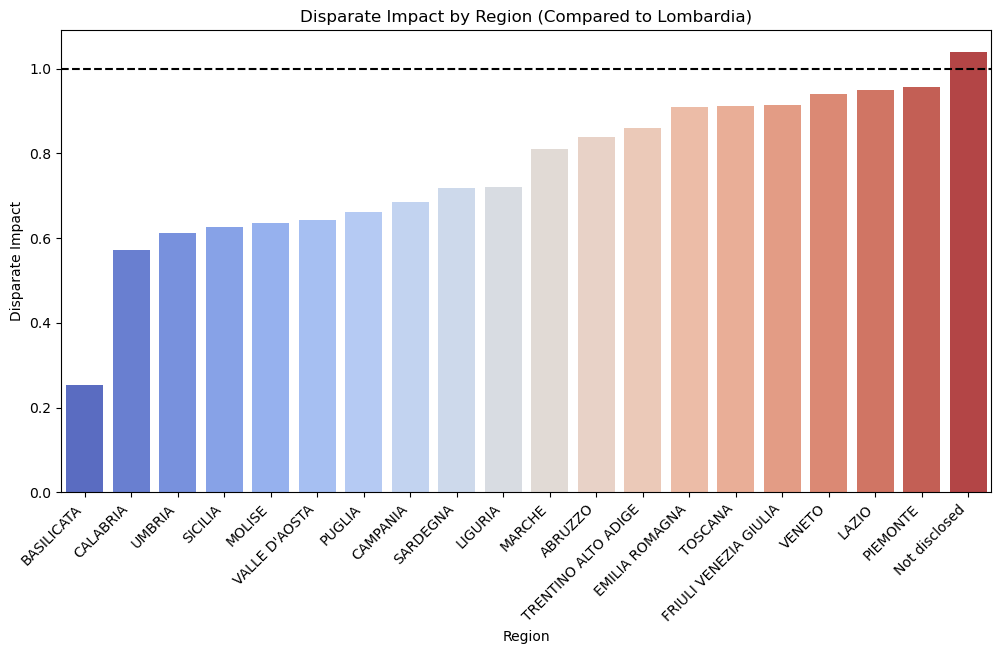

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Region", y="Disparate Impact", data=fairness_df, palette="coolwarm")
plt.axhline(y=1, color="black", linestyle="--")  
plt.xlabel("Region")
plt.ylabel("Disparate Impact")
plt.title("Disparate Impact by Region (Compared to Lombardia)")
plt.xticks(rotation=45, ha="right")  
plt.show()


/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_975/3578202212.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Region", y="Statistical Parity Difference", data=fairness_df, palette="coolwarm")


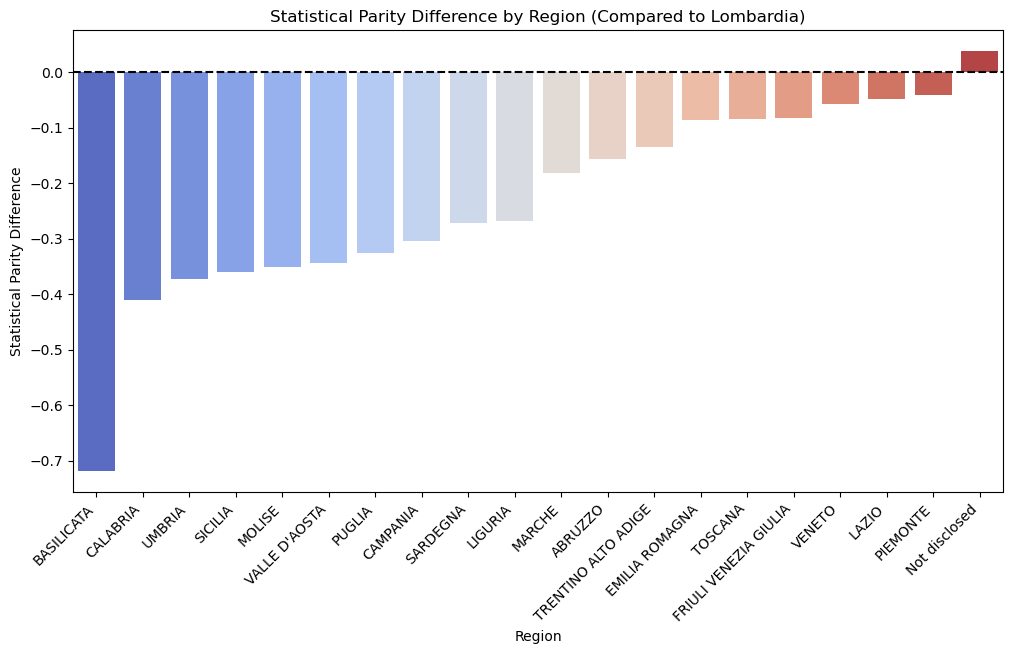

In [ ]:
fairness_df = fairness_df.sort_values(by="Statistical Parity Difference")

plt.figure(figsize=(12, 6))
sns.barplot(x="Region", y="Statistical Parity Difference", data=fairness_df, palette="coolwarm")
plt.axhline(y=0, color="black", linestyle="--") 
plt.xlabel("Region")
plt.ylabel("Statistical Parity Difference")
plt.title("Statistical Parity Difference by Region (Compared to Lombardia)")
plt.xticks(rotation=45, ha="right")  
plt.show()


- The Disparate Impact for some regions (e.g., Basilicata, Calabria, Umbria) is significantly lower than 0.8, which indicates strong bias against those regions compared to Lombardia.
- The Statistical Parity Difference for some regions is also highly negative, meaning candidates from those regions are less likely to receive favorable 
outcomes.
- In general, we can see that there is bias when it comes to the regions from south of Italy.

# Mitigation: Reweight

In [ ]:
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

In [ ]:
# Apply Reweighting
reweigher = Reweighing(privileged_groups=[{"cand_domicile_region": 8}],
                        unprivileged_groups=[{"cand_domicile_region": r} for r in all_regions if r != 8])

reweighted_dataset = reweigher.fit_transform(aif_dataset)
reweighted_dataset.instance_weights = reweighted_dataset.instance_weights.clip(0.1, 1.2)


In [ ]:
# Compute fairness metrics after reweighting
fairness_results_after = []
for region in unprivileged_regions:
    metric_after = BinaryLabelDatasetMetric(
        reweighted_dataset,
        privileged_groups=[{"cand_domicile_region": 8}],
        unprivileged_groups=[region]
    )
    
    fairness_results_after.append({
        "Region": region["cand_domicile_region"],
        "Disparate Impact": metric_after.disparate_impact(),
        "Statistical Parity Difference": metric_after.statistical_parity_difference()
    })

In [ ]:
fairness_df_after = pd.DataFrame(fairness_results_after)
fairness_df_after = fairness_df_after.fillna(0)
fairness_df_after = fairness_df_after.sort_values(by="Disparate Impact")


In [ ]:
# Map region numbers to names
fairness_df_after["Region"] = fairness_df_after["Region"].map(region_label_mapping).fillna("Unknown Region")


In [ ]:
fairness_df_after = fairness_df_after.sort_values(by="Statistical Parity Difference")

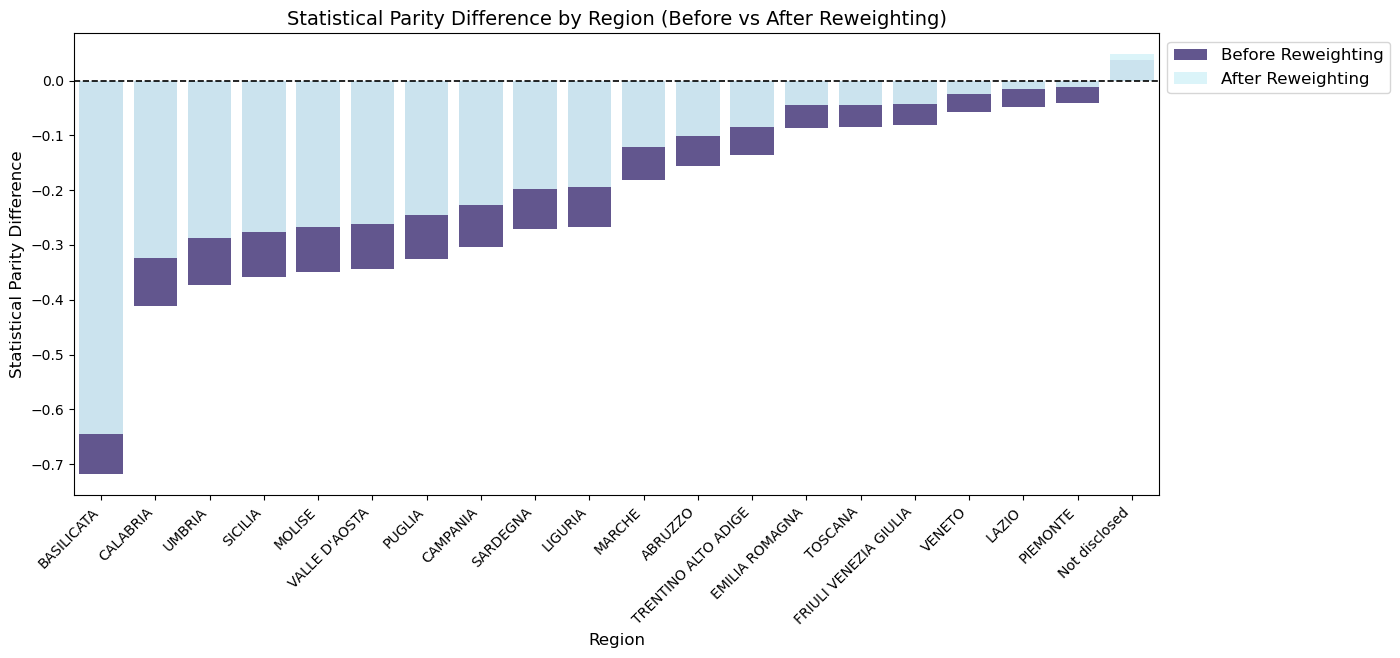

In [ ]:
import seaborn as sns

plt.figure(figsize=(14, 6))

sns.barplot(x="Region", y="Statistical Parity Difference", data=fairness_df, color="#34207E", alpha=0.8, label="Before Reweighting")  
sns.barplot(x="Region", y="Statistical Parity Difference", data=fairness_df_after, color="#D1F6FF", alpha=0.9, label="After Reweighting") 

plt.axhline(y=0, color="black", linestyle="--", linewidth=1.2) 

plt.xlabel("Region", fontsize=12)
plt.ylabel("Statistical Parity Difference", fontsize=12)
plt.title("Statistical Parity Difference by Region (Before vs After Reweighting)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)

plt.show()


After applying the reweighning technique again by using the AIF 360 Toolkit, we can observe that the scores for the statistical parity difference by region have slightly improved.

# Mitigation: Disparate Impact Remover
### Link: https://www.holisticai.com/blog/bias-mitigation-strategies-techniques-for-classification-tasks
### Article: https://arxiv.org/abs/1412.3756

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata

# Step 1: Compute the empirical CDF of Y for each group
def empirical_cdf(values):
    """Compute the empirical CDF for a given set of values."""
    sorted_vals = np.sort(values)
    ranks = rankdata(sorted_vals, method='average') / len(sorted_vals)
    return dict(zip(sorted_vals, ranks))

# Step 2: Compute the quantile function for each protected group
group_cdfs = {}
for region in df["cand_domicile_region"].unique():
    group_values = df[df["cand_domicile_region"] == region]["favorable_outcome"]
    group_cdfs[region] = empirical_cdf(group_values)

# Step 3: Compute the median distribution (quantile function)
quantiles = np.linspace(0, 1, 100)  # 100 evenly spaced quantiles
group_quantiles = {region: np.percentile(df[df["cand_domicile_region"] == region]["favorable_outcome"], quantiles * 100)
                   for region in df["cand_domicile_region"].unique()}

median_distribution = np.median(np.array(list(group_quantiles.values())), axis=0)

# Step 4: Apply the median distribution to transform Y
def apply_median_distribution(value, region):
    """Replace Y value with its corresponding quantile from the median distribution."""
    cdf_val = group_cdfs[region].get(value, 0.5)  # Default to 0.5 if value not found
    index = np.searchsorted(quantiles, cdf_val)
    return median_distribution[index]

df["favorable_outcome_repaired"] = df.apply(lambda row: apply_median_distribution(row["favorable_outcome"], row["cand_domicile_region"]), axis=1)

# Step 5: Verify the results
print(df[["cand_domicile_region", "favorable_outcome", "favorable_outcome_repaired"]].head())


   cand_domicile_region  favorable_outcome  favorable_outcome_repaired
0                    20                  1                         1.0
1                    20                  1                         1.0
2                    20                  1                         1.0
3                    20                  1                         1.0
4                    20                  1                         1.0


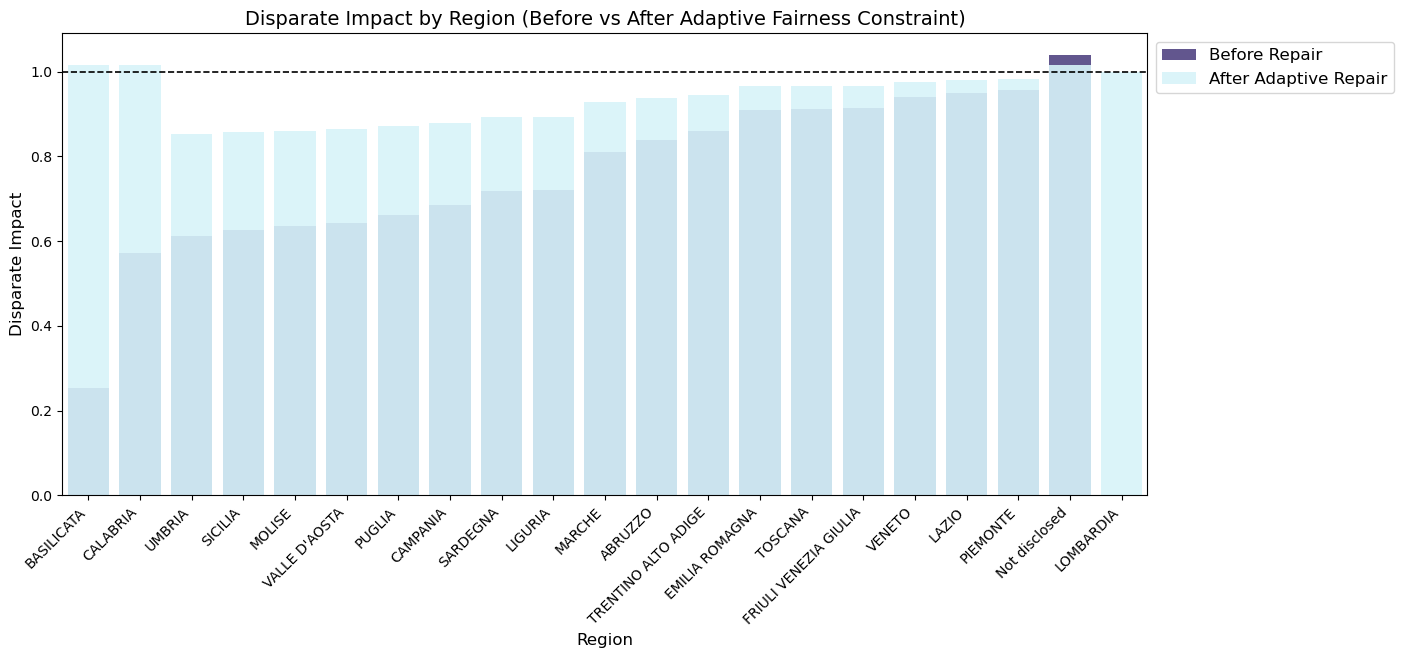

In [ ]:
# Implement an adaptive fairness constraint
# Instead of a fixed threshold, adapt based on regional disparities

# Compute the mean and standard deviation of Disparate Impact before repair
mean_di_before = fairness_df["Disparate Impact"].mean()
std_di_before = fairness_df["Disparate Impact"].std()

# Define an adaptive threshold: within 1 standard deviation of the mean
adaptive_lower_bound = max(0.5, mean_di_before - std_di_before)  # Prevent going too low
adaptive_upper_bound = min(1.5, mean_di_before + std_di_before)  # Prevent excessive overcorrection

# Apply the adaptive fairness constraint
df["favorable_outcome_repaired"] = np.clip(df["favorable_outcome_repaired"], adaptive_lower_bound, adaptive_upper_bound)

# Recompute Disparate Impact after applying the adaptive fairness constraint
fairness_results_adaptive = []
for region in df["cand_domicile_region"].unique():
    region_df = df[df["cand_domicile_region"] == region]
    
    # Compute DI: Probability of favorable outcome for region / Probability for Lombardia (region 8)
    p_favorable_region = region_df["favorable_outcome_repaired"].mean()
    p_favorable_privileged = df[df["cand_domicile_region"] == 8]["favorable_outcome_repaired"].mean()

    di_adaptive = p_favorable_region / p_favorable_privileged if p_favorable_privileged > 0 else np.nan
    
    fairness_results_adaptive.append({
        "Region": region_label_mapping.get(region, "Unknown Region"),
        "Disparate Impact": di_adaptive
    })

fairness_df_adaptive = pd.DataFrame(fairness_results_adaptive).fillna(0).sort_values(by="Disparate Impact")

# Plot Disparate Impact before and after applying the adaptive fairness constraint
plt.figure(figsize=(14, 6))
sns.barplot(x="Region", y="Disparate Impact", data=fairness_df, color="#34207E", alpha=0.8, label="Before Repair")  
sns.barplot(x="Region", y="Disparate Impact", data=fairness_df_adaptive, color="#D1F6FF", alpha=0.9, label="After Adaptive Repair")  

plt.axhline(y=1, color="black", linestyle="--", linewidth=1.2)  

plt.xlabel("Region", fontsize=12)
plt.ylabel("Disparate Impact", fontsize=12)
plt.title("Disparate Impact by Region (Before vs After Adaptive Fairness Constraint)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)

plt.show()


After applying the Disparate Impact Remover Mitigation technique, mentioned in the article provided, we can see that the results have significantly improved. The regions which showed the worst scores (Basilicata and Calabria) now reach a score of 1. Furthermore, the ones that have been showing good scores before kept their initial results. 

### 4. Check for bias if the candidates working in the same province are privilidged

In [ ]:
df = rm_df.copy()

# Define a binary column: True if the job is in the same province as domicile
df["same_province"] = df["job_work_province"] == df["cand_domicile_province"]

df["successful_placement"] = (df["match_score"] >= 80).astype(int)

df_province = df[["same_province", "successful_placement"]]

aif_dataset = StandardDataset(
    df_province,
    label_name="successful_placement",  
    favorable_classes=[1],  
    protected_attribute_names=["same_province"],  # Whether candidate is working in the same province
    privileged_classes=[[True]]  # Candidates working in the same province are privileged
)

/Users/kristinabaycheva/anaconda3/lib/python3.11/site-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]


In [ ]:
# Define privileged (local placements) and unprivileged (relocation) groups
privileged_groups = [{"same_province": True}]
unprivileged_groups = [{"same_province": False}]

metric = BinaryLabelDatasetMetric(
    aif_dataset, 
    privileged_groups=privileged_groups,  
    unprivileged_groups=unprivileged_groups
)

print(f"Disparate Impact: {metric.disparate_impact()}")
print(f"Statistical Parity Difference: {metric.statistical_parity_difference()}")


Disparate Impact: 0.9308622747555124
Statistical Parity Difference: -0.06532804003057013


/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_975/170093796.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Metric", y="Value", data=fairness_df, palette="coolwarm")


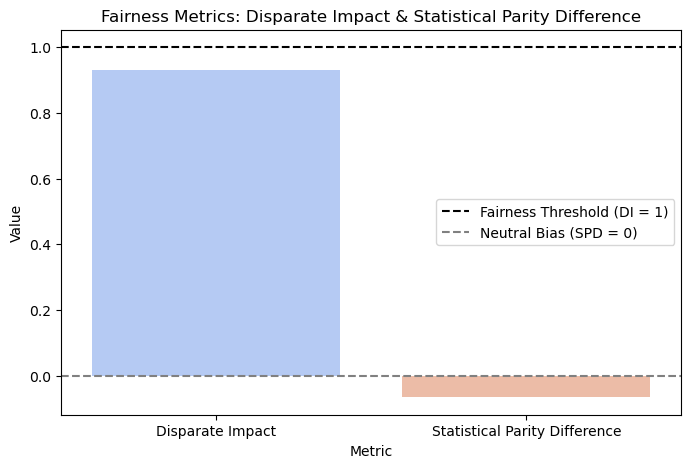

In [ ]:
fairness_results = {
    "Metric": ["Disparate Impact", "Statistical Parity Difference"],
    "Value": [metric.disparate_impact(), metric.statistical_parity_difference()]
}

fairness_df = pd.DataFrame(fairness_results)

plt.figure(figsize=(8, 5))
sns.barplot(x="Metric", y="Value", data=fairness_df, palette="coolwarm")
plt.axhline(y=1, color="black", linestyle="--", label="Fairness Threshold (DI = 1)")
plt.axhline(y=0, color="gray", linestyle="--", label="Neutral Bias (SPD = 0)")
plt.ylabel("Value")
plt.title("Fairness Metrics: Disparate Impact & Statistical Parity Difference")
plt.legend()
plt.show()


- The results show that candidates working in the same province as their domicile have a higher probability of successful placement than those relocating.
- The Disparate Impact is slightly below 0.93, which can be concerning but it's not something extremely alarming at this moment 
- The Statistical Parity Difference is negative, meaning relocated candidates receive fewer favorable outcomes.

# Appendix: 

# Alternative method for detecting bias - FairLearn tool
#### Link: https://iamrajatroy.medium.com/evaluate-model-fairness-with-fairlearn-97a8985074fd
#### Link: https://fairlearn.org/main/api_reference/generated/fairlearn.metrics.demographic_parity_difference.html
#### The demographic parity difference of 0 means that all groups have the same selection rate.

### 1. Gender bias

In [ ]:
df1 = rm_df.copy()
from fairlearn.metrics import demographic_parity_difference

df1["cand_gender"] = df1["cand_gender"].astype(int)

# Define the target variable (match score threshold for fairness)
df1["favorable_outcome"] = (df1["match_score"] >= 80).astype(int)  

# Define rule-based prediction (same as favorable_outcome for now)
df1["predicted_outcome"] = df1["favorable_outcome"]

# Keep only necessary columns
df1 = df1[["cand_gender", "favorable_outcome", "predicted_outcome"]]

# Define variables
y_true = df1["favorable_outcome"]  # Ground truth (from dataset)
y_pred = df1["predicted_outcome"]  # Rule-based prediction
protected_attr = df1["cand_gender"]  

# Compute bias metrics
dp_diff = demographic_parity_difference(y_true, y_pred, sensitive_features=protected_attr)

print(f"Demographic Parity Difference: {dp_diff}")



Demographic Parity Difference: 0.0030056634406304683


### 2. Age

In [ ]:
df1 = rm_df.copy()
from fairlearn.metrics import demographic_parity_difference

df1["cand_age_bucket"] = df1["cand_age_bucket"].astype(int)

df1["favorable_outcome"] = (df1["match_score"] >= 80).astype(int) 

df1["predicted_outcome"] = df1["favorable_outcome"]

df1 = df1[["cand_age_bucket", "favorable_outcome", "predicted_outcome"]]

y_true = df1["favorable_outcome"]  # Ground truth (from dataset)
y_pred = df1["predicted_outcome"]  # Rule-based prediction
protected_attr = df1["cand_age_bucket"]  # Regional category

# Compute bias metrics
dp_diff = demographic_parity_difference(y_true, y_pred, sensitive_features=protected_attr)

print(f"Demographic Parity Difference: {dp_diff}")



Demographic Parity Difference: 0.026919872795473476


### 3. Domicile Region

In [ ]:
df1 = rm_df.copy()
from fairlearn.metrics import demographic_parity_difference

df1["cand_domicile_region"] = df1["cand_domicile_region"].astype(int)

df1["favorable_outcome"] = (df1["match_score"] >= 80).astype(int)  

df1["predicted_outcome"] = df1["favorable_outcome"]

df1 = df1[["cand_domicile_region", "favorable_outcome", "predicted_outcome"]]

# Define variables
y_true = df1["favorable_outcome"]  # Ground truth (from dataset)
y_pred = df1["predicted_outcome"]  # Rule-based prediction
protected_attr = df1["cand_domicile_region"]  # Regional category

# Compute bias metrics
dp_diff = demographic_parity_difference(y_true, y_pred, sensitive_features=protected_attr)

print(f"Demographic Parity Difference: {dp_diff}")


Demographic Parity Difference: 0.7560975609756098


Demographic Parity Difference (0.756)

Ideally, this value should be close to 0 (max ±0.1 is acceptable).
0.756 is high, meaning some regions are getting significantly fewer favorable outcomes than others.
This suggests structural bias based on cand_domicile_region.


### 4. Same working and residing province

In [ ]:
df1 = rm_df.copy()
from fairlearn.metrics import demographic_parity_difference

df1["same_province"] = df1["job_work_province"] == df1["cand_domicile_province"]

df1["favorable_outcome"] = (df1["match_score"] >= 80).astype(int)  

df1["predicted_outcome"] = df1["favorable_outcome"]

df1 = df1[["same_province", "favorable_outcome", "predicted_outcome"]]

# Define variables
y_true = df1["favorable_outcome"]  # Ground truth (from dataset)
y_pred = df1["predicted_outcome"]  # Rule-based prediction
protected_attr = df1["same_province"]  # Regional category

# Compute bias metrics
dp_diff = demographic_parity_difference(y_true, y_pred, sensitive_features=protected_attr)

print(f"Demographic Parity Difference: {dp_diff}")



Demographic Parity Difference: 0.06532804003057013


# Other tests: KL Divergence, Chi-square and Cramer's V

In [ ]:
from scipy.stats import chi2_contingency, entropy
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

### 1. Gender

In [ ]:
df = rm_df.copy()

df["cand_gender"] = df["cand_gender"].astype(int)

df["favorable_outcome"] = (df["match_score"] >= 80).astype(int)  

privileged_group = df[df["cand_gender"] == 0]  
unprivileged_group = df[df["cand_gender"] == 1]  

# Compute rates
privileged_rate = privileged_group["favorable_outcome"].mean()
unprivileged_rate = unprivileged_group["favorable_outcome"].mean()

# Compute fairness metrics
statistical_parity_difference = unprivileged_rate - privileged_rate
mean_difference = statistical_parity_difference
disparate_impact = unprivileged_rate / privileged_rate if privileged_rate > 0 else np.nan

# Chi-Square Test for independence
contingency_table = pd.crosstab(df["cand_gender"], df["favorable_outcome"])
chi2, p, _, _ = chi2_contingency(contingency_table)

# Define metadata for SDV
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

# Generate synthetic data using SDV GaussianCopulaSynthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df)
synth_data = synthesizer.sample(len(df))

# Compute KL Divergence for bias detection
real_gender_dist = df["cand_gender"].value_counts(normalize=True).sort_index()
synth_gender_dist = synth_data["cand_gender"].value_counts(normalize=True).sort_index()
kl_divergence = entropy(real_gender_dist, synth_gender_dist)

# Print fairness metrics
print(f"Disparate Impact: {disparate_impact:.4f}")
print(f"Statistical Parity Difference: {statistical_parity_difference:.4f}")
print(f"Mean Difference: {mean_difference:.4f}")
print(f"Chi-Square Test p-value: {p:.4f}")
print(f"KL Divergence (Real vs. Synthetic): {kl_divergence:.4f}")

if p < 0.05:
    print("Significant bias detected based on Chi-Square Test.")
else:
    print("No significant bias detected based on Chi-Square Test.")

if kl_divergence > 0.1: 
    print("Potential bias detected due to significant KL Divergence.")
else:
    print("No significant bias detected based on KL Divergence.")

/Users/kristinabaycheva/anaconda3/lib/python3.11/site-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/Users/kristinabaycheva/anaconda3/lib/python3.11/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Disparate Impact: 0.9966
Statistical Parity Difference: -0.0030
Mean Difference: -0.0030
Chi-Square Test p-value: 0.0335
KL Divergence (Real vs. Synthetic): 0.0000
Significant bias detected based on Chi-Square Test.
No significant bias detected based on KL Divergence.


In [ ]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    df,
    synth_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 17.09it/s]|
Column Shapes Score: 90.15%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:02<00:00, 37.57it/s]|
Column Pair Trends Score: 80.3%

Overall Score (Average): 85.22%



In [ ]:
synth_data["privileged"] = (synth_data["cand_gender"] == 1).astype(int)
# Count occurrences of privileged and unprivileged groups
privileged_counts = synth_data["privileged"].value_counts()
# Calculate proportions
privileged_proportions = synth_data["privileged"].value_counts(normalize=True) * 100

print("Counts:\n", privileged_counts)
print("\nProportions (%):\n", privileged_proportions)

Counts:
 privileged
1    97779
0    95695
Name: count, dtype: int64

Proportions (%):
 privileged
1    50.538574
0    49.461426
Name: proportion, dtype: float64


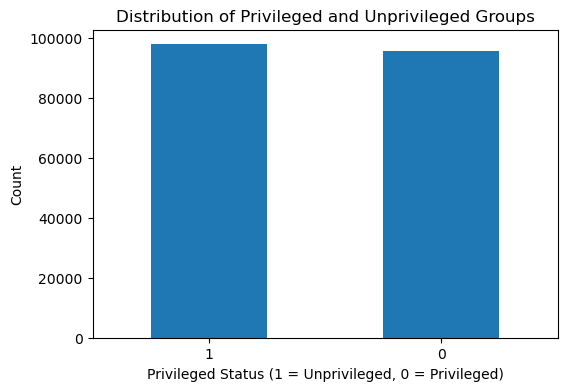

In [ ]:
plt.figure(figsize=(6, 4))
synth_data["privileged"].value_counts().plot(kind="bar")
plt.xlabel("Privileged Status (1 = Unprivileged, 0 = Privileged)")
plt.ylabel("Count")
plt.title("Distribution of Privileged and Unprivileged Groups")
plt.xticks(rotation=0)
plt.show()


#### Cramer's V

In [ ]:
from scipy.stats import chi2_contingency
import numpy as np

# Compute Chi-Square test
contingency_table = pd.crosstab(df["cand_gender"], df["favorable_outcome"])
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Compute Cramér’s V
n = np.sum(contingency_table.values)
phi2 = chi2 / n
r, k = contingency_table.shape
cramers_v = np.sqrt(phi2 / min(r-1, k-1))

print(f"Cramér’s V: {cramers_v:.4f}")

Cramér’s V: 0.0048


- Chi-square shows that bias exists
- Cramer’s V measures how strong the bias is
- In our case, chi-square detects bias, however, Cramer’s V shows a very weak result, meaning that intervention might not be needed. 
- Chi-square is sensitive to lage sample sizes and may detect trivial differences as significant. a significant result doen't indicate the strength of the association

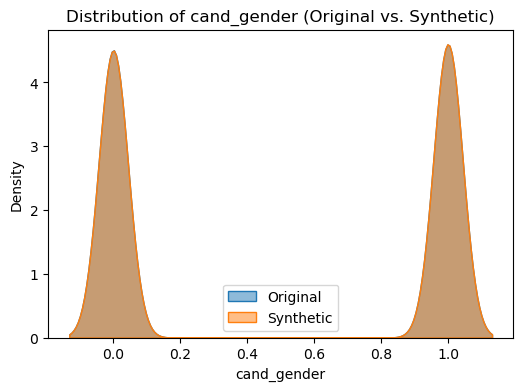

In [ ]:
numeric_columns = ["cand_gender"] 

for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(df[col], label="Original", fill=True, alpha=0.5)
    sns.kdeplot(synth_data[col], label="Synthetic", fill=True, alpha=0.5)
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.title(f"Distribution of {col} (Original vs. Synthetic)")
    plt.legend()
    plt.show()


The distribution between original and synthetic data for gender is almost perfect 

### 2. Age

In [ ]:
df = rm_df.copy()

# Convert 'cand_age_bucket' to integer
df["cand_age_bucket"] = df["cand_age_bucket"].astype(int)

# Define the favorable outcome 
df["favorable_outcome"] = (df["match_score"] >= 80).astype(int)

# Define privileged and unprivileged groups
privileged_age = 1  # Age group 25-34 (mapped as 1)
all_ages = df["cand_age_bucket"].unique()
unprivileged_ages = [age for age in all_ages if age != privileged_age]  # All except 25-34

# Compute group proportions
privileged_group = df[df["cand_age_bucket"] == privileged_age]
unprivileged_group = df[df["cand_age_bucket"].isin(unprivileged_ages)]  # Include all other ages

# Compute positive outcome rates
privileged_rate = privileged_group["favorable_outcome"].mean()
unprivileged_rate = unprivileged_group["favorable_outcome"].mean()

# Compute fairness metrics
statistical_parity_difference = unprivileged_rate - privileged_rate
mean_difference = statistical_parity_difference
disparate_impact = (unprivileged_rate / privileged_rate) if privileged_rate > 0 else np.nan

# Chi-Square Test for independence
contingency_table = pd.crosstab(df["cand_age_bucket"], df["favorable_outcome"])
chi2, p, _, _ = chi2_contingency(contingency_table)

# Define metadata for SDV
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

# Generate synthetic data using SDV GaussianCopulaSynthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df)
synth_data = synthesizer.sample(len(df))

# Compute KL Divergence for bias detection
real_age_dist = df["cand_age_bucket"].value_counts(normalize=True).sort_index()
synth_age_dist = synth_data["cand_age_bucket"].value_counts(normalize=True).sort_index()
kl_divergence = entropy(real_age_dist, synth_age_dist)

print(f"\nDisparate Impact: {disparate_impact:.4f}")
print(f"Statistical Parity Difference: {statistical_parity_difference:.4f}")
print(f"Mean Difference: {mean_difference:.4f}")
print(f"Chi-Square Test p-value: {p:.4f}")
print(f"KL Divergence (Real vs. Synthetic): {kl_divergence:.4f}")

if p < 0.05:
    print("Significant bias detected based on Chi-Square Test.")
else:
    print("No significant bias detected based on Chi-Square Test.")

if kl_divergence > 0.1: 
    print("Potential bias detected due to significant KL Divergence.")
else:
    print("No significant bias detected based on KL Divergence.")


/Users/kristinabaycheva/anaconda3/lib/python3.11/site-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/Users/kristinabaycheva/anaconda3/lib/python3.11/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(



Disparate Impact: 1.0147
Statistical Parity Difference: 0.0130
Mean Difference: 0.0130
Chi-Square Test p-value: 0.0000
KL Divergence (Real vs. Synthetic): 0.0000
Significant bias detected based on Chi-Square Test.
No significant bias detected based on KL Divergence.


In [ ]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    df,
    synth_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 17.43it/s]|
Column Shapes Score: 90.15%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:02<00:00, 41.72it/s]|
Column Pair Trends Score: 80.31%

Overall Score (Average): 85.23%



In [ ]:
# Define privileged group (Age 25-34 is mapped as 1)
synth_data["privileged"] = (synth_data["cand_age_bucket"] == 1).astype(int)
# Count occurrences of privileged and unprivileged groups
privileged_counts = synth_data["privileged"].value_counts()
# Calculate proportions
privileged_proportions = synth_data["privileged"].value_counts(normalize=True) * 100

print("Counts:\n", privileged_counts)
print("\nProportions (%):\n", privileged_proportions)


Counts:
 privileged
0    120863
1     72611
Name: count, dtype: int64

Proportions (%):
 privileged
0    62.469893
1    37.530107
Name: proportion, dtype: float64


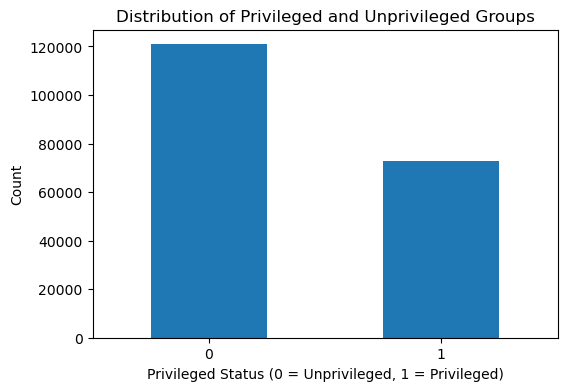

In [ ]:
plt.figure(figsize=(6, 4))
synth_data["privileged"].value_counts().plot(kind="bar")
plt.xlabel("Privileged Status (0 = Unprivileged, 1 = Privileged)")
plt.ylabel("Count")
plt.title("Distribution of Privileged and Unprivileged Groups")
plt.xticks(rotation=0)
plt.show()


In [ ]:
age_group_rates = df.groupby("cand_age_bucket")["favorable_outcome"].mean()
print("Favorable Outcome Rates by Age Bucket:\n", age_group_rates)

Favorable Outcome Rates by Age Bucket:
 cand_age_bucket
0    0.891613
1    0.884338
2    0.890548
3    0.903032
4    0.911258
Name: favorable_outcome, dtype: float64


In [ ]:
age_group_rates = synth_data.groupby("cand_age_bucket")["favorable_outcome"].mean()
print("Favorable Outcome Rates by Age Bucket:\n", age_group_rates)

Favorable Outcome Rates by Age Bucket:
 cand_age_bucket
0    0.891792
1    0.892909
2    0.892147
3    0.894027
4    0.895235
Name: favorable_outcome, dtype: float64


In [ ]:
# Original dataset
from itertools import combinations
from scipy.stats import chi2_contingency

# Get all possible pairs of age groups
age_pairs = list(combinations(df["cand_age_bucket"].unique(), 2))

for age1, age2 in age_pairs:
    subset = df[df["cand_age_bucket"].isin([age1, age2])]
    contingency_table = pd.crosstab(subset["cand_age_bucket"], subset["favorable_outcome"])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    print(f"Chi-Square Test between Age {age1} and Age {age2}: p-value = {p:.4f}")

Chi-Square Test between Age 1 and Age 4: p-value = 0.0000
Chi-Square Test between Age 1 and Age 2: p-value = 0.0013
Chi-Square Test between Age 1 and Age 3: p-value = 0.0000
Chi-Square Test between Age 1 and Age 0: p-value = 0.0019
Chi-Square Test between Age 4 and Age 2: p-value = 0.0000
Chi-Square Test between Age 4 and Age 3: p-value = 0.0028
Chi-Square Test between Age 4 and Age 0: p-value = 0.0000
Chi-Square Test between Age 2 and Age 3: p-value = 0.0000
Chi-Square Test between Age 2 and Age 0: p-value = 0.6766
Chi-Square Test between Age 3 and Age 0: p-value = 0.0000


In [ ]:
# Synthetic one

# Get all possible pairs of age groups in synthetic data
age_pairs = list(combinations(synth_data["cand_age_bucket"].unique(), 2))

for age1, age2 in age_pairs:
    subset = synth_data[synth_data["cand_age_bucket"].isin([age1, age2])]
    contingency_table = pd.crosstab(subset["cand_age_bucket"], subset["favorable_outcome"])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    print(f"Chi-Square Test between Age {age1} and Age {age2} (Synthetic Data): p-value = {p:.4f}")


Chi-Square Test between Age 2 and Age 1 (Synthetic Data): p-value = 0.6909
Chi-Square Test between Age 2 and Age 3 (Synthetic Data): p-value = 0.4004
Chi-Square Test between Age 2 and Age 0 (Synthetic Data): p-value = 0.8959
Chi-Square Test between Age 2 and Age 4 (Synthetic Data): p-value = 0.2783
Chi-Square Test between Age 1 and Age 3 (Synthetic Data): p-value = 0.5832
Chi-Square Test between Age 1 and Age 0 (Synthetic Data): p-value = 0.6328
Chi-Square Test between Age 1 and Age 4 (Synthetic Data): p-value = 0.3876
Chi-Square Test between Age 3 and Age 0 (Synthetic Data): p-value = 0.3900
Chi-Square Test between Age 3 and Age 4 (Synthetic Data): p-value = 0.6867
Chi-Square Test between Age 0 and Age 4 (Synthetic Data): p-value = 0.2730


#### Cramer's V

In [ ]:
from scipy.stats import chi2_contingency
import numpy as np

# Compute Chi-Square test
contingency_table = pd.crosstab(df["cand_age_bucket"], df["favorable_outcome"])
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Compute Cramér’s V
n = np.sum(contingency_table.values)
phi2 = chi2 / n
r, k = contingency_table.shape
cramers_v = np.sqrt(phi2 / min(r-1, k-1))

print(f"Cramér’s V: {cramers_v:.4f}")


Cramér’s V: 0.0283


- Chi-square shows that bias exists
- Cramer’s V measures how strong the bias is
- In our case, chi-square detects bias, however, Cramer’s V shows a very weak result, meaning that intervention might not be needed. 
- Chi-square is sensitive to lage sample sizes and may detect trivial differences as significant. a significant result doen't indicate the strength of the association

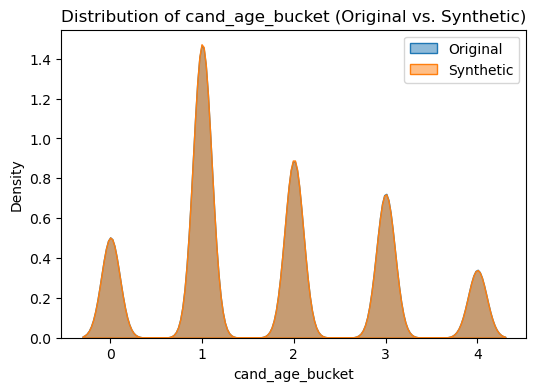

In [ ]:
numeric_columns = ["cand_age_bucket"] 

for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(df[col], label="Original", fill=True, alpha=0.5)
    sns.kdeplot(synth_data[col], label="Synthetic", fill=True, alpha=0.5)
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.title(f"Distribution of {col} (Original vs. Synthetic)")
    plt.legend()
    plt.show()


Again, we can see that the synthetic data generated for the different age buckets resembles the original one to a very big extent

In [ ]:
# Compute favorable outcome rates by age group
real_outcomes = df.groupby("cand_age_bucket")["favorable_outcome"].mean()
synth_outcomes = synth_data.groupby("cand_age_bucket")["favorable_outcome"].mean()

comparison_df = pd.DataFrame({"Original Data": real_outcomes, "Synthetic Data": synth_outcomes})
print(comparison_df)


                 Original Data  Synthetic Data
cand_age_bucket                               
0                     0.891613        0.891792
1                     0.884338        0.892909
2                     0.890548        0.892147
3                     0.903032        0.894027
4                     0.911258        0.895235


### 3. Domicile Region

In [ ]:
df = rm_df.copy()

privileged_regions = [6, 8, 12]
df["privileged"] = df["cand_domicile_region"].isin(privileged_regions).astype(int)

df["favorable_outcome"] = (df["match_score"] >= 80).astype(int) 

# Chi-Square Test for independence
contingency_table = pd.crosstab(df["privileged"], df["favorable_outcome"])
chi2, p, _, _ = chi2_contingency(contingency_table)

# Define metadata for SDV
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

# Generate synthetic data using SDV GaussianCopulaSynthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df)
synth_data = synthesizer.sample(len(df))

# Compute KL Divergence for bias detection
real_region_dist = df["cand_domicile_region"].value_counts(normalize=True).sort_index()
synth_region_dist = synth_data["cand_domicile_region"].value_counts(normalize=True).sort_index()
kl_divergence = entropy(real_region_dist, synth_region_dist)

print(f"Chi-Square Test p-value: {p:.4f}")
print(f"KL Divergence (Real vs. Synthetic): {kl_divergence:.4f}")

if p < 0.05:
    print("Significant bias detected based on Chi-Square Test.")
else:
    print("No significant bias detected based on Chi-Square Test.")

if kl_divergence > 0.1: 
    print("Potential bias detected due to significant KL Divergence.")
else:
    print("No significant bias detected based on KL Divergence.")

/Users/kristinabaycheva/anaconda3/lib/python3.11/site-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/Users/kristinabaycheva/anaconda3/lib/python3.11/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Chi-Square Test p-value: 0.0000
KL Divergence (Real vs. Synthetic): 0.9121
Significant bias detected based on Chi-Square Test.
Potential bias detected due to significant KL Divergence.


In [ ]:
df = rm_df.copy()


df["cand_domicile_region"] = df["cand_domicile_region"].astype(int)

# Define the favorable outcome 
df["favorable_outcome"] = (df["match_score"] >= 80).astype(int)

# Define privileged and unprivileged groups
privileged_region = 8  # Lombardia
all_regions = df["cand_domicile_region"].unique()
unprivileged_regions = [region for region in all_regions if region != privileged_region]  

# Compute group proportions
privileged_group = df[df["cand_domicile_region"] == privileged_region]
unprivileged_group = df[df["cand_domicile_region"].isin(unprivileged_regions)]  

# Compute positive outcome rates
privileged_rate = privileged_group["favorable_outcome"].mean()
unprivileged_rate = unprivileged_group["favorable_outcome"].mean()

# Compute fairness metrics
statistical_parity_difference = unprivileged_rate - privileged_rate
mean_difference = statistical_parity_difference
disparate_impact = (unprivileged_rate / privileged_rate) if privileged_rate > 0 else np.nan

# Chi-Square Test for independence
contingency_table = pd.crosstab(df["cand_domicile_region"], df["favorable_outcome"])
chi2, p, _, _ = chi2_contingency(contingency_table)

# Define metadata for SDV
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

# Generate synthetic data using SDV GaussianCopulaSynthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df)
synth_data = synthesizer.sample(len(df))

# Compute KL Divergence for bias detection
real_reg_dist = df["cand_domicile_region"].value_counts(normalize=True).sort_index()
synth_reg_dist = synth_data["cand_domicile_region"].value_counts(normalize=True).sort_index()
kl_divergence = entropy(real_reg_dist, synth_reg_dist)

print(f"\nDisparate Impact: {disparate_impact:.4f}")
print(f"Statistical Parity Difference: {statistical_parity_difference:.4f}")
print(f"Mean Difference: {mean_difference:.4f}")
print(f"Chi-Square Test p-value: {p:.4f}")
print(f"KL Divergence (Real vs. Synthetic): {kl_divergence:.4f}")

if p < 0.05:
    print("Significant bias detected based on Chi-Square Test.")
else:
    print("No significant bias detected based on Chi-Square Test.")

if kl_divergence > 0.1: 
    print("Potential bias detected due to significant KL Divergence.")
else:
    print("No significant bias detected based on KL Divergence.")


/Users/kristinabaycheva/anaconda3/lib/python3.11/site-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/Users/kristinabaycheva/anaconda3/lib/python3.11/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(



Disparate Impact: 0.8916
Statistical Parity Difference: -0.1044
Mean Difference: -0.1044
Chi-Square Test p-value: 0.0000
KL Divergence (Real vs. Synthetic): 0.9057
Significant bias detected based on Chi-Square Test.
Potential bias detected due to significant KL Divergence.


#### Cramer's V

In [ ]:
from scipy.stats import chi2_contingency
import numpy as np

# Compute Chi-Square test
contingency_table = pd.crosstab(df["cand_domicile_region"], df["favorable_outcome"])
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Compute Cramér’s V
n = np.sum(contingency_table.values)
phi2 = chi2 / n
r, k = contingency_table.shape
cramers_v = np.sqrt(phi2 / min(r-1, k-1))

print(f"Cramér’s V: {cramers_v:.4f}")


Cramér’s V: 0.2861


- Here we can see that we have higher score compared to Gender and Age

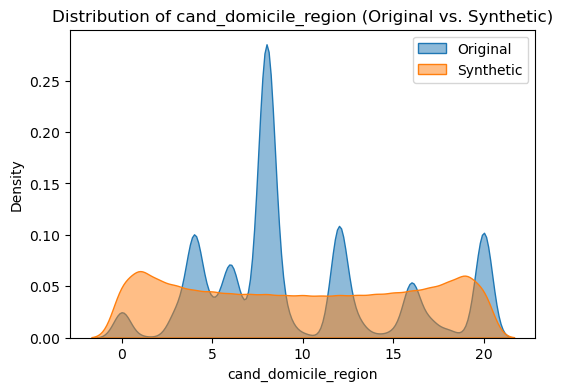

In [ ]:
numeric_columns = ["cand_domicile_region"] 

for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(df[col], label="Original", fill=True, alpha=0.5)
    sns.kdeplot(synth_data[col], label="Synthetic", fill=True, alpha=0.5)
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.title(f"Distribution of {col} (Original vs. Synthetic)")
    plt.legend()
    plt.show()


The synthetic dataset in the case for domicile region doesn't resemble that well the original one

# Wasserstein Distance
#### We decided also to measure Wasserstein Distance as in the article mentioned below it is suggested that: Disparate Impact might indicate fairness, but Wasserstein Distance reveals a clear difference in score distributions across groups — indicating hidden bias
#### The authors of it recommend using Wasserstein distance along traditional fairness metrics as DI
#### Link to article: https://securedata.lol/camera_ready/37.pdf

### 1. Gender

In [ ]:
from scipy.stats import wasserstein_distance
import numpy as np

df = rm_df.copy()

# Define privileged and unprivileged groups based on gender
privileged_group = df[df["cand_gender"] == 1]["match_score"]  # Male
unprivileged_group = df[df["cand_gender"] == 0]["match_score"]  # Female

# Compute Wasserstein Distance based on match scores
wasserstein_dist = wasserstein_distance(privileged_group, unprivileged_group)
print(f"Wasserstein Distance (Gender): {wasserstein_dist:.4f}")


Wasserstein Distance (Gender): 0.2277


### 2. Age

In [ ]:
from scipy.stats import wasserstein_distance
df = rm_df.copy()

# Filter groups
privileged_scores = df[df["cand_age_bucket"] == 1]["match_score"] # 25-34 year olds
unprivileged_scores = df[df["cand_age_bucket"] != 1]["match_score"]

# Compute Wasserstein Distance
age_wasserstein_dist = wasserstein_distance(privileged_scores, unprivileged_scores)
print(f"Wasserstein Distance (Age): {age_wasserstein_dist:.4f}")


Wasserstein Distance (Age): 0.5337


### 3. Domicile Region

In [ ]:
from scipy.stats import wasserstein_distance
df = rm_df.copy()

# Filter groups
privileged_scores = df[df["cand_domicile_region"] == 8]["match_score"] # Lombardia
unprivileged_scores = df[df["cand_domicile_region"] != 8]["match_score"]

# Compute Wasserstein Distance
age_wasserstein_dist = wasserstein_distance(privileged_scores, unprivileged_scores)
print(f"Wasserstein Distance (Domicile Region): {age_wasserstein_dist:.4f}")


Wasserstein Distance (Domicile Region): 5.7997


#### From all measurements we can see that Wasserstein distance indicated low scores, therefore no to minimal bias for gender and age. However, the score for the domicile region is high which suggests that there is significant bias 

## Overal conclusion:
#### Given all the tests implemented, we can see that there is no to minimal bias when it comes to gender and age, however, for domicile region bias was edetedted everywhere and was mitigated using reweightning and disparate impact remover techniques